In [1]:
import re
import os
import numpy as np
import pandas as pd
# df = pd.read_csv('test_reliability_0z_href_only.csv')
# df = pd.read_csv('stats_0z_href_only.csv')
# df["spc_success_ratio"] = df["spc_success_ratio"].astype(float)
# df["spc_pod"]           = df["spc_pod"].astype(float)
import matplotlib

def sheet(df):
    import dtale
    return dtale.show(df)


# PICK WHICH YOU WANT:

# root_in, root_out, wind_adj, for_paper, suffixes = "", "plots/", True, False, ["", "_absolutely_calibrated", "_href_only", "_href_only_absolutely_calibrated"]
# root_in, root_out, wind_adj, for_paper, suffixes = "", "plots_for_paper/", False, True, ["_href_only"]
root_in, root_out, wind_adj, for_paper, suffixes = "", "plots_for_paper/", False, True, ["_href_only_more_days", "_href_only_since_spc_implementation"]
# root_in, root_out, wind_adj, for_paper, suffixes = "csvs_2021/", "plots_2021/", False, False, ["", "_absolutely_calibrated", "_href_only", "_href_only_absolutely_calibrated"]

def titleize_suffix(suffix):
    return re.compile(r"_(\w)").sub(lambda match: f" {match[1].upper()}", suffix)

In [2]:
# tor_df = df[df["event"] == "tornado"].copy()
# tor_df["spc_success_ratio"] = tor_df["spc_success_ratio"].astype(float)
# tor_df["spc_pod"]           = tor_df["spc_pod"].astype(float)
# tor_df

In [3]:
# sig_tor_df = df[df["event"] == "sig_tornado_gated_by_tornado"].copy()
# sig_tor_df = sig_tor_df[sig_tor_df["threshold"] == 0.1].copy()
# sig_tor_df.index = range(len(sig_tor_df))
# sig_tor_df["spc_success_ratio"] = sig_tor_df["spc_success_ratio"].astype(float)
# sig_tor_df["spc_pod"]           = sig_tor_df["spc_pod"].astype(float)
# sig_tor_df

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

In [5]:
tornado_colors = [
    (0.0,  (1.,1.,1.))
  , (0.01, (0.570,0.570,0.570))
  , (0.02, (0.067,0.541,0.078))
  , (0.05, (0.541,0.278,0.165))
  , (0.1,  (0.996,0.780,0.180))
  , (0.15, (0.988,0.051,0.106))
  , (0.30, (0.988,0.157,0.988))
  , (0.45, (0.565,0.224,0.918))
  , (0.60, (0.082,0.310,0.537))
  ]

wind_hail_colors = [
    (0.0,  (1.,1.,1.))
  , (0.02, (0.570,0.570,0.570))
  , (0.05, (0.541,0.278,0.165))
  , (0.15, (0.996,0.780,0.180))
  , (0.30, (0.988,0.051,0.106))
  , (0.45, (0.988,0.157,0.988))
  , (0.60, (0.565,0.224,0.918))
  ]

sig_colors = [
    (0.0,  (1.,1.,1.))
  , (0.1,  (0.3,0.3,0.3))
  ]

# Regular tornado colors, but dark gray 10%
sig_tornado_more_colors = [
    (0.0,  (1.,1.,1.))
  , (0.01, (0.570,0.570,0.570))
  , (0.02, (0.067,0.541,0.078))
  , (0.05, (0.541,0.278,0.165))
  , (0.1,  (0.3,0.3,0.3))
  , (0.15, (0.988,0.051,0.106))
  , (0.30, (0.988,0.157,0.988))
  , (0.45, (0.565,0.224,0.918))
  , (0.60, (0.082,0.310,0.537))
  ]

# Regular wind and hail colors, but additional dark gray 10%
sig_wind_hail_more_colors = [
    (0.0,  (1.,1.,1.))
  , (0.02, (0.570,0.570,0.570))
  , (0.05, (0.541,0.278,0.165))
  , (0.1,  (0.3,0.3,0.3))
  , (0.15, (0.996,0.780,0.180))
  , (0.30, (0.988,0.051,0.106))
  , (0.45, (0.988,0.157,0.988))
  , (0.60, (0.565,0.224,0.918))
  ]

def lookup(key, pairs):
    return dict(pairs)[key]

In [6]:
def p_value(p):
    if p < .001: return "p<.001"
    if p < .01:  return f"p={p:.3f}".replace("0.", ".")
    return f"p={p:.2f}".replace("0.", ".")

p_value(0.5)

'p=.50'

In [7]:
def perf_plot(csv_path, nc_label, spc_label, nice_event, event, sig_event, event_colors, sig_event_colors, xmax, extra_csi_thresholds, label_positions=dict(), nc_sig_label_position=None):
    suffix = (re.compile(r"_(\d+)z(_\w+)?\.csv").search(csv_path)[2] or "")

    full_df = pd.read_csv(root_in + csv_path)

    df = full_df[full_df["event"] == event].copy()
    df.index = range(len(df))
    df["spc_success_ratio"] = df["spc_success_ratio"].astype(float)
    df["spc_pod"]           = df["spc_pod"].astype(float)

    sig_df = full_df[full_df["event"] == sig_event].copy()
    sig_df = sig_df[sig_df["threshold"] == 0.1].copy()
    sig_df.index = range(len(sig_df))
    sig_df["spc_success_ratio"] = sig_df["spc_success_ratio"].astype(float)
    sig_df["spc_pod"]           = sig_df["spc_pod"].astype(float)
    
    event_colors     = [lookup(threshold, event_colors)     for threshold in df["threshold"]]
    sig_event_colors = [lookup(threshold, sig_event_colors) for threshold in sig_df["threshold"]]

    fig, ax = plt.subplots()

    ax.set_xlim(0,.4)
    ax.set_ylim(0,1)
    ax.set_xticks(np.arange(0.,xmax + .01,0.1))
    ax.set_yticks(np.arange(0.,1.01,0.1))
    ax.set_xlabel("Success Ratio")
    ax.set_ylabel("POD")

    xmax = ax.get_xlim()[1]
    ymax = ax.get_ylim()[1]

    if not for_paper:
        ax.set_title(f"{nice_event} Performance{titleize_suffix(suffix)}\n({df['days_count'][0]} Days, 2019/1-2022/5)", pad=15, fontdict={"fontweight":"bold"})
    else:
        ax.set_title(f"{nice_event} Performance", pad=15, fontdict={"fontweight":"bold"})
    # ax.set_aspect(1)
    
    # SPC
    ax.plot("spc_success_ratio", "spc_pod", zorder=-1, c=(0,0,0), linewidth=1.5, data=df)
    ax.scatter("spc_success_ratio", "spc_pod", s=200, marker="o", c=event_colors, data=df)

    # NC
    nc_xs = df["nadocast_success_ratio"][df["nadocast_threshold_days"] >= 2]
    nc_ys = df["nadocast_pod"][df["nadocast_threshold_days"] >= 2]
    ax.plot(nc_xs, nc_ys, zorder=-1, c=(0,0,0), linewidth=1.5, linestyle="--")
    nadocast_fills = [event_colors[i] if df["p_value_nadocast_csi_better"][i] < 0.05 and (i+1 == len(df) or df["spc_pod"][i] != df["spc_pod"][i+1]) and df["spc_threshold_days"][i] >= 1 else (1,1,1) for i in df["threshold"][df["nadocast_threshold_days"] >= 2].index]
    ax.scatter(nc_xs, nc_ys, s=200, marker="v", color=nadocast_fills, edgecolors=event_colors, linewidths=2)

    # SPC Sig
    ax.scatter("spc_success_ratio", "spc_pod", s=400, marker="o", c=sig_event_colors, data=sig_df)

    # NC Sig
    nadocast_fills = [sig_event_colors[i] if sig_df["p_value_nadocast_csi_better"][i] < 0.05 else (1,1,1) for i in range(len(sig_df["threshold"]))]
    ax.scatter("nadocast_success_ratio", "nadocast_pod", s=400, marker="v", color=nadocast_fills, edgecolors=sig_event_colors, linewidths=2, data=sig_df)

    # Series labels
    series_label_size = 10 if for_paper else 12
    x1, y1 = ax.transData.transform((df["nadocast_success_ratio"][1], df["nadocast_pod"][1]))
    x2, y2 = ax.transData.transform((df["nadocast_success_ratio"][2], df["nadocast_pod"][2]))
    nc_legend_rot = np.degrees(np.arctan2(y2 - y1, x2 - x1))
    ax.text(0.5*df["nadocast_success_ratio"][1] + 0.5*df["nadocast_success_ratio"][2], 0.5*df["nadocast_pod"][1] + 0.5*df["nadocast_pod"][2], nc_label, fontsize=series_label_size, horizontalalignment="center", va="bottom", fontweight="bold", rotation=nc_legend_rot, rotation_mode="anchor", linespacing=0.9)
#     ax.text(df["nadocast_success_ratio"][0] - 0.035*xmax*np.cos(np.radians(legend_rot)), df["nadocast_pod"][0] - 0.035*ymax*np.sin(np.radians(legend_rot)), f"NC 0Z",  fontsize=12, horizontalalignment="right", va="center", fontweight="bold", rotation=legend_rot, rotation_mode="anchor")
    x1, y1 = ax.transData.transform((df["spc_success_ratio"][1], df["spc_pod"][1]))
    x2, y2 = ax.transData.transform((df["spc_success_ratio"][2], df["spc_pod"][2]))
    spc_legend_rot = np.degrees(np.arctan2(y2 - y1, x2 - x1))
    if (x1, y1) != (x2, y2):
        ax.text(0.5*df["spc_success_ratio"][1] + 0.5*df["spc_success_ratio"][2], 0.5*df["spc_pod"][1] + 0.5*df["spc_pod"][2], spc_label, fontsize=series_label_size, horizontalalignment="center", va="bottom", fontweight="bold", rotation=spc_legend_rot, rotation_mode="anchor", linespacing=0.9)
    else:
        ax.text(df["spc_success_ratio"][1] - 0.03*xmax, df["spc_pod"][1], spc_label, fontsize=series_label_size, horizontalalignment="right", va="center", fontweight="bold", linespacing=0.9)
#     ax.text(df["spc_success_ratio"][0]      - 0.035*xmax*np.cos(np.radians(legend_rot)), df["spc_pod"][0]      - 0.035*ymax*np.sin(np.radians(legend_rot)), f"SPC 0Z", fontsize=12, horizontalalignment="right", va="center", fontweight="bold", rotation=legend_rot, rotation_mode="anchor")

    white_outline = [pe.withStroke(linewidth=2, foreground=(1,1,1))]

    # NC symbol labels
    for i in range(len(df["threshold"])):
        ndays = df["nadocast_threshold_days"][i]
        x = df["nadocast_success_ratio"][i]
        y = df["nadocast_pod"][i]
        if ndays <= 1: continue
        if np.isnan(x): continue
        if np.isnan(y): continue
        p = df["p_value_nadocast_csi_better"][i]
        p_str = f"\n{p_value(p)}" if (i+1 == len(df) or df["spc_pod"][i] != df["spc_pod"][i+1]) and df["spc_threshold_days"][i] >= 1 else ""
        dx, dy, ha, va = {
            "default": (0.03, 0.01, "left", "center") if x < 0.92*xmax else (-0.03, 0.01, "right", "center"),
            "n":       ( 0,  0.035, "center", "bottom"),
            "s":       ( 0, -0.035, "center", "top"),
            "e":       ( 0.03, 0,   "left",   "center"),
            "w":       (-0.03, 0,   "right",  "center"),
            "se":      ( 0.02, 0,   "left",   "top"),
            "sw":      (-0.02, 0,   "right",  "top"),
            "ne":      ( 0.03, 0,   "left",   "bottom"),
            "nw":      (-0.03, 0,   "right",  "bottom"),
        }[label_positions.get(f"nc_{df['threshold'][i]}", "default")]
        ax.text(x + dx*xmax, y + dy*ymax, f"{ndays} days{p_str}", fontsize=7, horizontalalignment=ha, va=va, c=event_colors[i], path_effects=white_outline)

    # SPC symbol labels
    for i in range(len(df["threshold"])):
        ndays = df["spc_threshold_days"][i]
        x = df["spc_success_ratio"][i]
        y = df["spc_pod"][i]
        if ndays <= 1: continue
        if np.isnan(x): continue
        if np.isnan(y): continue
        dx, dy, ha, va = {
            "default": ( 0, -0.035,     "center", "top") if y > 0.05*ymax else (0, 0.035, "center", "bottom"),
            "n":       ( 0,  0.035,     "center", "bottom"),
            "s":       ( 0, -0.035,     "center", "top"),
            "ssw":     ( 0, -0.03,      "right",  "top"),
            "e":       ( 0.03,   0,     "left",   "center"),
            "w":       (-0.03,   0,     "right",  "center"),
            "se":      ( 0.025, -0.015, "left",   "top"),
            "sw":      (-0.025, -0.015, "right",  "top"),
            "ne":      ( 0.025,  0.015, "left",   "bottom"),
            "nw":      (-0.025,  0.015, "right",  "bottom"),
        }[label_positions.get(f"spc_{df['threshold'][i]}", "default")]
        ax.text(x + dx*xmax, y + dy*ymax, f"{ndays} days", fontsize=7, horizontalalignment=ha, va=va, c=event_colors[i], path_effects=white_outline)

    # NC sig symbol labels
    for i in range(len(sig_df["threshold"])):
        ndays = sig_df["nadocast_threshold_days"][i]
        if ndays <= 1: continue
        x = sig_df["nadocast_success_ratio"][i]
        y = sig_df["nadocast_pod"][i]
        if np.isnan(x): continue
        if np.isnan(y): continue
        p = sig_df["p_value_nadocast_csi_better"][i]
        dx, dy, ha, va = {
            "default": ( 0, -0.05, "center", "top") if y > 0.15*ymax else (0, 0.05, "center", "bottom"),
            "right":   ( 0.04,  0, "left",   "center"),
            "n":       ( 0,  0.05, "center", "bottom"),
            "s":       ( 0, -0.05, "center", "top"),
            "e":       ( 0.035, 0, "left",   "center"),
            "w":       (-0.035, 0, "right",  "center"),
            "se":      ( 0.025, 0, "left",   "top"),
            "sw":      (-0.025, 0, "right",  "top"),
            "ne":      ( 0.04,  0, "left",   "bottom"),
            "nw":      (-0.04,  0, "right",  "bottom"),
        }[nc_sig_label_position or label_positions.get("nc_sig", "default")]
        bounded_label = "" if for_paper else " Bounded"
        ax.text(x + dx*xmax, y + dy*ymax, f"NC Sig{bounded_label}\n{ndays} days\n{p_value(p)}", fontsize=7, horizontalalignment=ha, va=va, c=sig_event_colors[i], path_effects=white_outline)


    # SPC sig symbol labels
    for i in range(len(sig_df["threshold"])):
        ndays = sig_df["spc_threshold_days"][i]
        if ndays <= 1: continue
        x = sig_df["spc_success_ratio"][i]
        y = sig_df["spc_pod"][i]
        if np.isnan(x): continue
        if np.isnan(y): continue
        dx, dy, ha, va = {
            "default": (0, -0.05, "center", "top") if y > 0.07*ymax else (-0.035, 0, "right", "center"),
            "n":       ( 0,  0.05, "center", "bottom"),
            "s":       ( 0, -0.05, "center", "top"),
            "e":       ( 0.035, 0, "left",   "center"),
            "w":       (-0.035, 0, "right",  "center"),
            "se":      ( 0.03,  0, "left",   "top"),
            "sw":      (-0.03,  0, "right",  "top"),
            "ne":      ( 0.03,  0, "left",   "bottom"),
            "nw":      (-0.03,  0, "right",  "bottom"),
        }[label_positions.get("spc_sig", "default")]
        ax.text(x + dx*xmax, y + dy*ymax, f"SPC Sig\n{ndays} days", fontsize=7, horizontalalignment=ha, va=va, c=sig_event_colors[i], path_effects=white_outline)


    # CSI 0.1 0.2 0.3 etc lines
    # cribbed from verif package
    ax.text(0.05, 1.01, "CSI     ", fontsize=7, horizontalalignment="right", c=(.5,.5,.5))
    threats = np.around(np.arange(0.1,xmax-.01,0.1), 1)
    for i in range(len(threats)):
        threat = threats[i]
        x = np.linspace(threat, 1, 400)
        label = ""
        if i == 0:
            label = "Threat score"
        y = 1.0 / (1 + 1.0/threat - 1.0 / x)
        ax.plot(x, y, 'k-', zorder=-1, linewidth=0.3, label=label)
        ax.text(threat, 1.01, str(threat), fontsize=7, horizontalalignment="center", c=(.5,.5,.5))

    # CSI 0.05 0.15 0.25 etc lines
    threats = extra_csi_thresholds
    for i in range(len(threats)):
        threat = threats[i]
        x = np.linspace(threat, 1, 400)
        y = 1.0 / (1 + 1.0/threat - 1.0 / x)
        ax.plot(x, y, 'k--', zorder=-1, linewidth=0.3)
        ax.text(threat, 1.01, str(threat), fontsize=7, horizontalalignment="center", c=(.5,.5,.5))

    legend_entries = []
    
    for threshold, color, nc_ndays, spc_ndays in zip(df["threshold"], event_colors, df["nadocast_threshold_days"], df["spc_threshold_days"]):
        if nc_ndays >= 2 or spc_ndays >= 2:
            legend_entries.append(matplotlib.patches.Patch(color=color, label=f"≥{int(threshold*100)}%"))

    legend_entries.append(matplotlib.patches.Patch(color=(0,0,0,0), label=f""))
    for threshold, color in zip(sig_df["threshold"], sig_event_colors):
        legend_entries.append(matplotlib.patches.Patch(color=color, label=f"≥{int(threshold*100)}% Sig."))
        
    ax.legend(handles=legend_entries, loc="upper right")
        
    # (nadocast|spc_day_1)(_href_only|_href_ablations)?(_absolutely_calibrated)?_(tornado|wind|wind_adj|hail|sig_tornado|sig_wind|sig_wind_adj|sig_hail|tornado_\w+_\d+)(_gated_by_\w+)?_(\d{8})_t(\d+)z
    t_z    = (re.compile(r"_(\d+)z(_\w+)?\.csv").search(csv_path)[1] or "")
    t_z    = "00" if t_z == "0" else t_z
    out_path = f"{root_out}performance{suffix}_{event}_t{t_z}z.png"
    plt.savefig(out_path, dpi=200)
    os.system(f"oxipng -o max --strip safe --libdeflater {out_path}")
    plt.show()

In [20]:
{"a":"b"}.get("a","d")

'b'

Processing: plots_for_paper/performance_href_only_more_days_tornado_t00z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 197229 bytes
    File size = 197412 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 0        126636 bytes
    IDAT size = 126636 bytes (70593 bytes decrease)
    file size = 126714 bytes (70698 bytes = 35.81% decrease)
Output: plots_for_paper/performance_href_only_more_days_tornado_t00z.png


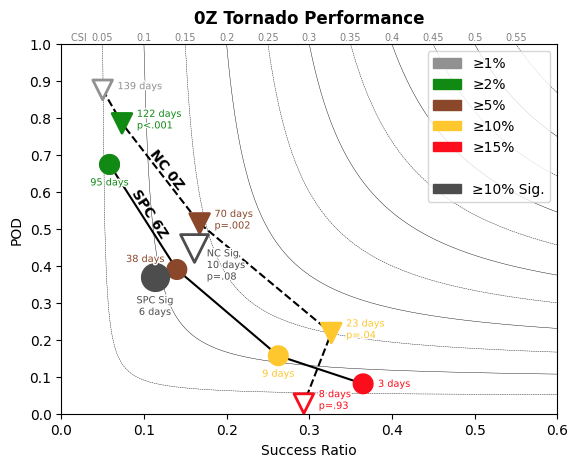

Processing: plots_for_paper/performance_href_only_more_days_wind_t00z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 200236 bytes
    File size = 200419 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 0        129860 bytes
    IDAT size = 129860 bytes (70376 bytes decrease)
    file size = 129938 bytes (70481 bytes = 35.17% decrease)
Output: plots_for_paper/performance_href_only_more_days_wind_t00z.png


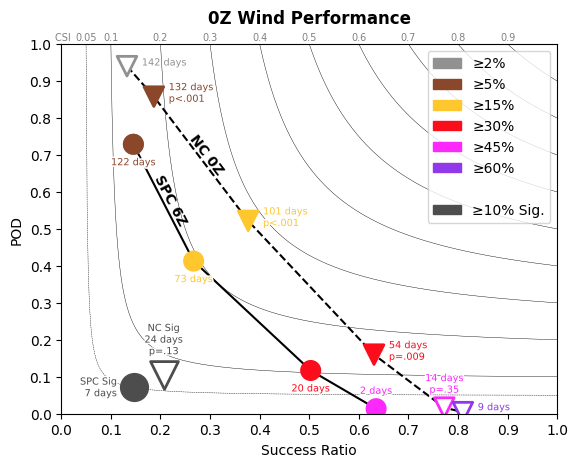

Processing: plots_for_paper/performance_href_only_more_days_hail_t00z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 192574 bytes
    File size = 192745 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 0        126239 bytes
    IDAT size = 126239 bytes (66335 bytes decrease)
    file size = 126317 bytes (66428 bytes = 34.46% decrease)
Output: plots_for_paper/performance_href_only_more_days_hail_t00z.png


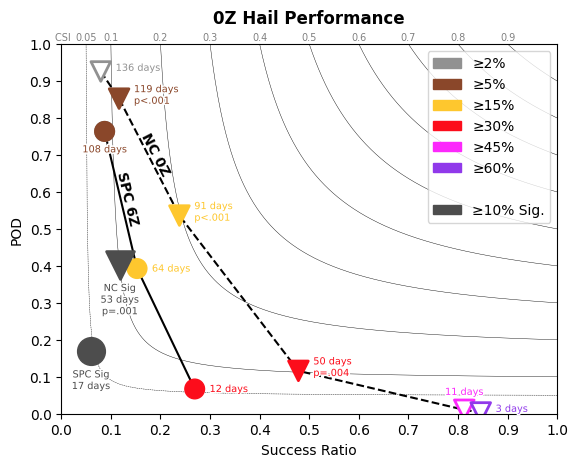

Processing: plots_for_paper/performance_href_only_more_days_tornado_t12z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 201603 bytes
    File size = 201786 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 0        128231 bytes
    IDAT size = 128231 bytes (73372 bytes decrease)
    file size = 128309 bytes (73477 bytes = 36.41% decrease)
Output: plots_for_paper/performance_href_only_more_days_tornado_t12z.png


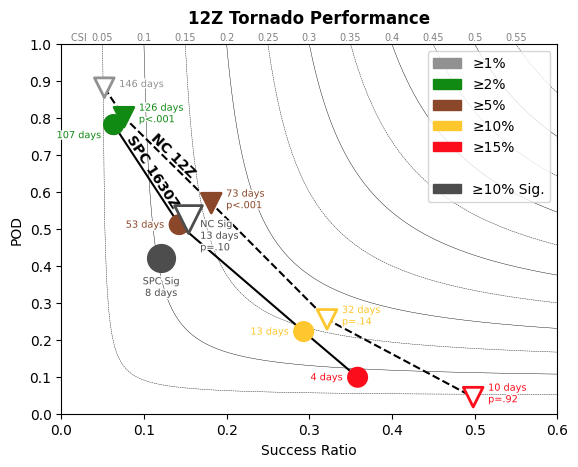

Processing: plots_for_paper/performance_href_only_more_days_wind_t12z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 204575 bytes
    File size = 204758 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 0        132187 bytes
    IDAT size = 132187 bytes (72388 bytes decrease)
    file size = 132265 bytes (72493 bytes = 35.40% decrease)
Output: plots_for_paper/performance_href_only_more_days_wind_t12z.png


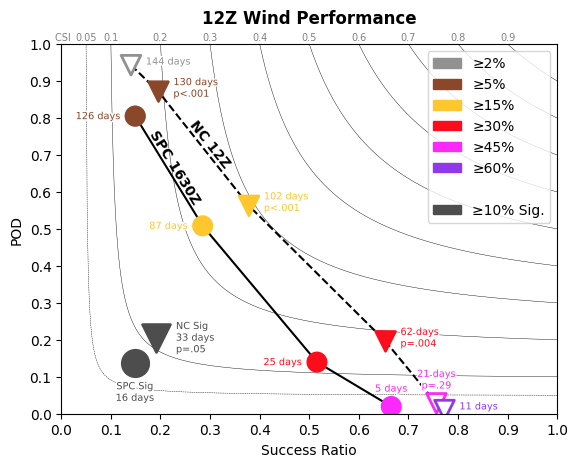

Processing: plots_for_paper/performance_href_only_more_days_hail_t12z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 201823 bytes
    File size = 202006 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 0        131353 bytes
    IDAT size = 131353 bytes (70470 bytes decrease)
    file size = 131431 bytes (70575 bytes = 34.94% decrease)
Output: plots_for_paper/performance_href_only_more_days_hail_t12z.png


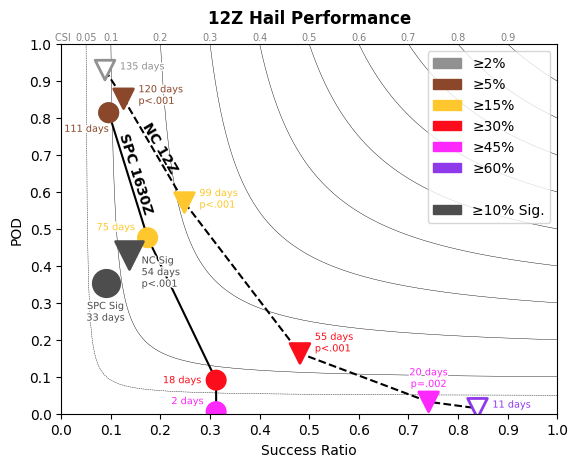

Processing: plots_for_paper/performance_href_only_since_spc_implementation_tornado_t00z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 200743 bytes
    File size = 200926 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 0        127129 bytes
    IDAT size = 127129 bytes (73614 bytes decrease)
    file size = 127207 bytes (73719 bytes = 36.69% decrease)
Output: plots_for_paper/performance_href_only_since_spc_implementation_tornado_t00z.png


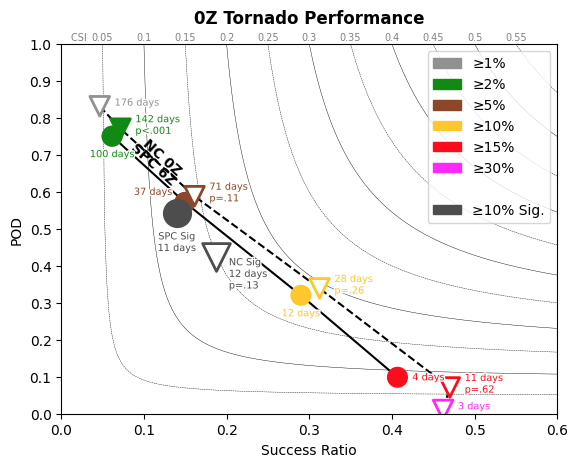

Processing: plots_for_paper/performance_href_only_since_spc_implementation_wind_t00z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 200184 bytes
    File size = 200367 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 0        130833 bytes
    IDAT size = 130833 bytes (69351 bytes decrease)
    file size = 130911 bytes (69456 bytes = 34.66% decrease)
Output: plots_for_paper/performance_href_only_since_spc_implementation_wind_t00z.png


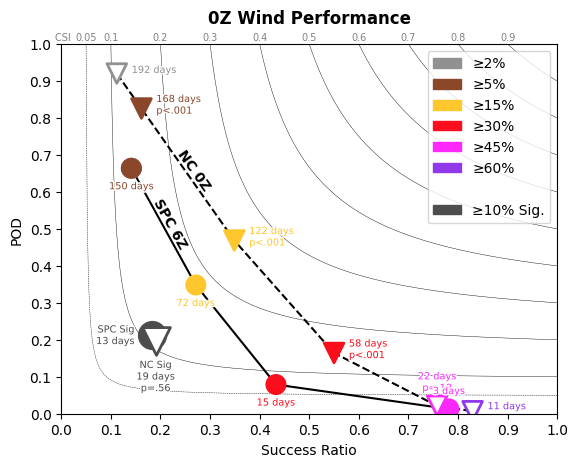

Processing: plots_for_paper/performance_href_only_since_spc_implementation_hail_t00z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 194389 bytes
    File size = 194560 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 0        126740 bytes
    IDAT size = 126740 bytes (67649 bytes decrease)
    file size = 126818 bytes (67742 bytes = 34.82% decrease)
Output: plots_for_paper/performance_href_only_since_spc_implementation_hail_t00z.png


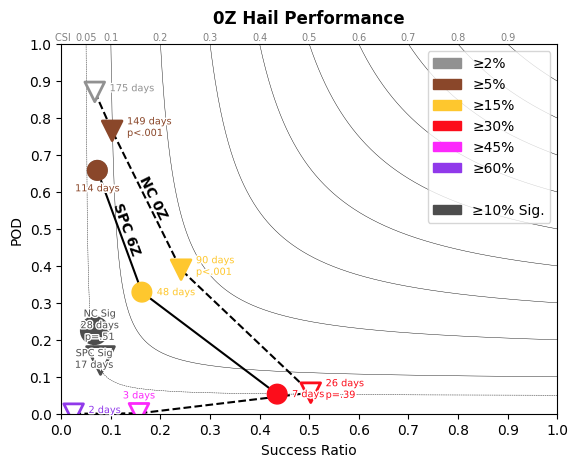

Processing: plots_for_paper/performance_href_only_since_spc_implementation_tornado_t12z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 208478 bytes
    File size = 208661 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 0        133620 bytes
    IDAT size = 133620 bytes (74858 bytes decrease)
    file size = 133698 bytes (74963 bytes = 35.93% decrease)
Output: plots_for_paper/performance_href_only_since_spc_implementation_tornado_t12z.png


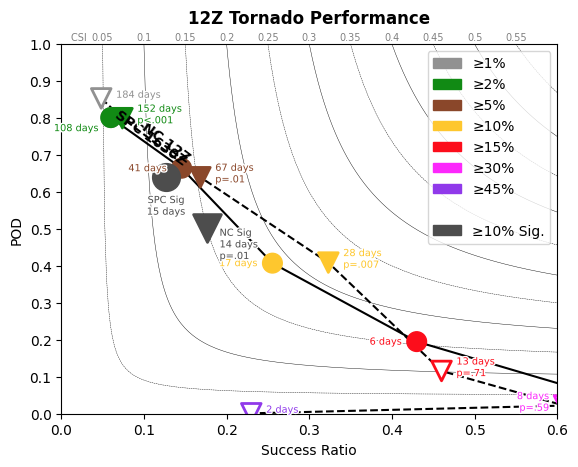

Processing: plots_for_paper/performance_href_only_since_spc_implementation_wind_t12z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 202467 bytes
    File size = 202650 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 0        131314 bytes
    IDAT size = 131314 bytes (71153 bytes decrease)
    file size = 131392 bytes (71258 bytes = 35.16% decrease)
Output: plots_for_paper/performance_href_only_since_spc_implementation_wind_t12z.png


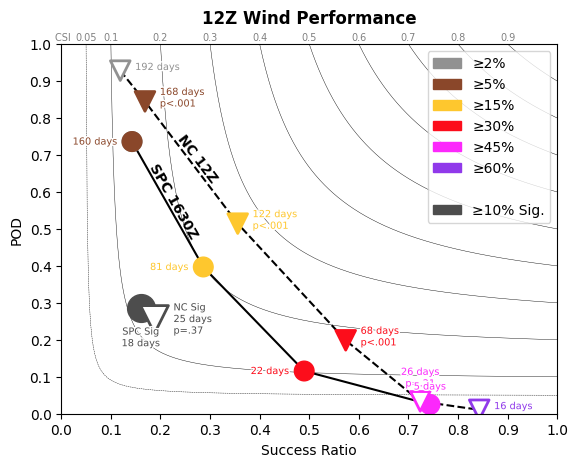

Processing: plots_for_paper/performance_href_only_since_spc_implementation_hail_t12z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 201096 bytes
    File size = 201279 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 0        130921 bytes
    IDAT size = 130921 bytes (70175 bytes decrease)
    file size = 130999 bytes (70280 bytes = 34.92% decrease)
Output: plots_for_paper/performance_href_only_since_spc_implementation_hail_t12z.png


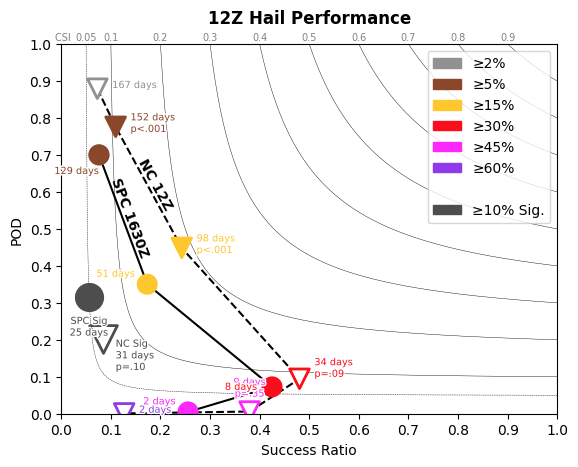

In [8]:
for suffix in suffixes:
    perf_plot(f"stats_0z{suffix}.csv", "NC 0Z", "SPC 6Z", "0Z Tornado", "tornado", "sig_tornado_gated_by_tornado", tornado_colors, sig_tornado_more_colors, 0.6, [0.05, 0.15, 0.25, 0.35, 0.45, 0.55], label_positions={"spc_0.05": "nw", "spc_0.15": "e", "nc_sig": "se"})
    perf_plot(f"stats_0z{suffix}.csv", "NC 0Z", "SPC 6Z", "0Z Wind", "wind", "sig_wind_gated_by_wind", wind_hail_colors, sig_wind_hail_more_colors, 1, [0.05], label_positions={"spc_sig": "w", "nc_0.45": "n", "nc_0.6": "ne"})
    wind_adj and perf_plot(f"stats_0z{suffix}.csv", "NC 0Z", "SPC 6Z", "0Z Wind Adjusted", "wind_adj", "sig_wind_adj_gated_by_wind_adj", wind_hail_colors, sig_wind_hail_more_colors, 1, [0.05])
    perf_plot(f"stats_0z{suffix}.csv", "NC 0Z", "SPC 6Z", "0Z Hail", "hail", "sig_hail_gated_by_hail", wind_hail_colors, sig_wind_hail_more_colors, 1, [0.05], label_positions={"spc_0.15": "e", "spc_0.3": "e", "nc_0.45": "n"})
    perf_plot(f"stats_12z{suffix}.csv", "NC 12Z", "SPC 1630Z", "12Z Tornado", "tornado", "sig_tornado_gated_by_tornado", tornado_colors, sig_tornado_more_colors, 0.6, [0.05, 0.15, 0.25, 0.35, 0.45, 0.55], label_positions={"spc_0.01": "sw", "spc_0.02": "sw", "spc_0.05": "w", "spc_0.1": "w", "spc_0.15": "w", "nc_sig": "se"})
    perf_plot(f"stats_12z{suffix}.csv", "NC 12Z", "SPC 1630Z", "12Z Wind", "wind", "sig_wind_gated_by_wind", wind_hail_colors, sig_wind_hail_more_colors, 1, [0.05], nc_sig_label_position="right", label_positions={"spc_0.02": "w", "spc_0.05": "w", "spc_0.15": "w", "spc_0.3": "w", "nc_0.45": "n"})
    wind_adj and perf_plot(f"stats_12z{suffix}.csv", "NC 12Z", "SPC 1630Z", "12Z Wind Adjusted", "wind_adj", "sig_wind_adj_gated_by_wind_adj", wind_hail_colors, sig_wind_hail_more_colors, 1, [0.05], nc_sig_label_position="right")
    perf_plot(f"stats_12z{suffix}.csv", "NC 12Z", "SPC 1630Z", "12Z Hail", "hail", "sig_hail_gated_by_hail", wind_hail_colors, sig_wind_hail_more_colors, 1, [0.05], label_positions={"spc_0.02": "ssw", "spc_0.05": "ssw", "spc_0.15": "nw", "spc_0.3": "w", "spc_0.45": "nw", "nc_0.3": "ne", "nc_0.45": "n", "nc_sig": "se"})
    if for_paper:
        continue
    perf_plot(f"stats_0z{suffix}.csv", "NC 0Z\nSig", "SPC 6Z\nSig", "0Z Sig Tornado", "sig_tornado_gated_by_tornado", None, sig_tornado_more_colors, [], 0.4, [0.05, 0.15, 0.25, 0.35])
    perf_plot(f"stats_0z{suffix}.csv", "NC 0Z\nSig", "SPC 6Z\nSig", "0Z Sig Wind", "sig_wind_gated_by_wind", None, sig_wind_hail_more_colors, [], 0.4, [0.05, 0.15, 0.25, 0.35])
    wind_adj and perf_plot(f"stats_0z{suffix}.csv", "NC 0Z\nSig", "SPC 6Z\nSig", "0Z Sig Wind Adjusted", "sig_wind_adj_gated_by_wind_adj", None, sig_wind_hail_more_colors, [], 0.4, [0.05, 0.15, 0.25, 0.35])
    perf_plot(f"stats_0z{suffix}.csv", "NC 0Z\nSig", "SPC 6Z\nSig", "0Z Sig Hail", "sig_hail_gated_by_hail", None, sig_wind_hail_more_colors, [], 0.4, [0.05, 0.15, 0.25, 0.35])
    perf_plot(f"stats_12z{suffix}.csv", "NC 12Z\nSig", "SPC 1630Z\nSig", "12Z Sig Tornado", "sig_tornado_gated_by_tornado", None, sig_tornado_more_colors, [], 0.4, [0.05, 0.15, 0.25, 0.35])
    perf_plot(f"stats_12z{suffix}.csv", "NC 12Z\nSig", "SPC 1630Z\nSig", "12Z Sig Wind", "sig_wind_gated_by_wind", None, sig_wind_hail_more_colors, [], 0.4, [0.05, 0.15, 0.25, 0.35])
    wind_adj and perf_plot(f"stats_12z{suffix}.csv", "NC 12Z\nSig", "SPC 1630Z\nSig", "12Z Sig Wind Adjusted", "sig_wind_adj_gated_by_wind_adj", None, sig_wind_hail_more_colors, [], 0.4, [0.05, 0.15, 0.25, 0.35])
    perf_plot(f"stats_12z{suffix}.csv", "NC 12Z\nSig", "SPC 1630Z\nSig", "12Z Sig Hail", "sig_hail_gated_by_hail", None, sig_wind_hail_more_colors, [], 0.4, [0.05, 0.15, 0.25, 0.35])

In [11]:
full_df = pd.read_csv(root_in + 'test_reliability_0z_href_only.csv')
# df = pd.read_csv('stats_0z_href_only.csv')
# df["spc_success_ratio"] = df["spc_success_ratio"].astype(float)
# df["spc_pod"]           = df["spc_pod"].astype(float)
full_df

,event,days_count,bin_low,bin_high_exclusive,spc_bin_days,nadocast_bin_days,spc_observed_rate,nadocast_observed_rate,spc_observed_rate_0.025_bootstrap,spc_observed_rate_0.975_bootstrap,nadocast_observed_rate_0.025_bootstrap,nadocast_observed_rate_0.975_bootstrap
0,tornado,155,0.00,0.01,155,155,0.000720,0.000304,0.000487,0.000986,0.000203,0.000420
1,tornado,155,0.01,0.02,0,123,NaN,0.013921,0.000000,0.000000,0.010085,0.017962
2,tornado,155,0.02,0.05,79,100,0.032623,0.038620,0.022169,0.044954,0.028648,0.049664
3,tornado,155,0.05,0.10,34,53,0.104233,0.129758,0.066901,0.140327,0.099695,0.160849
4,tornado,155,0.10,0.15,9,20,0.202077,0.370261,0.113579,0.356998,0.184900,0.494516
...,...,...,...,...,...,...,...,...,...,...,...,...
68,sig_hail_gated_by_hail,155,0.10,0.15,17,49,0.058644,0.076429,0.027587,0.110088,0.052520,0.102477
69,sig_hail_gated_by_hail,155,0.15,0.30,0,20,NaN,0.204061,0.000000,0.000000,0.135029,0.293830
70,sig_hail_gated_by_hail,155,0.30,0.45,0,1,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
71,sig_hail_gated_by_hail,155,0.45,0.60,0,0,NaN,NaN,0.000000,0.000000,0.000000,0.000000


In [17]:
def reliability_plot(csv_path, label, nc_or_spc, nice_event, event, event_colors, xmax, ymax, min_days=2):
    suffix = (re.compile(r"_(\d+)z(_\w+)?\.csv").search(csv_path)[2] or "")

    full_df = pd.read_csv(root_in + csv_path)

    df = full_df[full_df["event"] == event].copy()
    df = df[df["bin_low"] != 0].copy()
    df = df[df[f"{nc_or_spc}_bin_days"] >= min_days].copy()
    df.index = range(len(df))
    
    fig, ax = plt.subplots()

    ax.set_xlim(0,xmax)
    ax.set_ylim(0,ymax)
    ax.set_xticks(np.arange(0.,xmax + .01,0.1))
    ax.set_yticks(np.arange(0.,ymax + .01,0.1))
    ax.set_xlabel("Forecast Probability")
    ax.set_ylabel("Observed Frequency")
    ax.set_aspect(1)
    ax.grid(color=(.5,.5,.5), linestyle='-', linewidth=0.25)

    if not for_paper:
        ax.set_title(f"{label} {nice_event} Reliability{titleize_suffix(suffix)}\n({df['days_count'][0]} Days, 2019/1-2022/5)", fontdict={"fontweight":"bold"})
    else:
        ax.set_title(f"{label} {nice_event} Reliability", fontdict={"fontweight":"bold"})    

    white_outline = [pe.withStroke(linewidth=2, foreground=(1,1,1))]

    ax.plot([0,1], [0,1], linewidth=1.5, linestyle=":", color=(0,0,0))

    last_x, last_y = (0, 0)

    bin_highs = list(df["bin_high_exclusive"])
    if len(df) == 1: # SPC Sig
        bin_highs[0] = 1.0
    
    for i in df.index:
        color = lookup(df["bin_low"][i], event_colors)
        ndays = df[f"{nc_or_spc}_bin_days"][i]
        if i == 0 and len(df) >= 2:
            ax.text(bin_highs[i] + 0.02*xmax, df[f"{nc_or_spc}_observed_rate"][i], f"{ndays} days", fontsize=7, horizontalalignment="left", va="center", c=color, path_effects=white_outline)
        else:
            ax.text(0.5*df["bin_low"][i] + 0.5*min(xmax, bin_highs[i]), df[f"{nc_or_spc}_observed_rate"][i] + 0.01*ymax, f"{ndays} days", fontsize=7, horizontalalignment="center", va="bottom", c=color, path_effects=white_outline)

        linestyle = "--" if nc_or_spc == "nadocast" else "-"
        marker    = "v" if nc_or_spc == "nadocast" else "o"
        ax.plot([df["bin_low"][i], bin_highs[i]], [df[f"{nc_or_spc}_observed_rate"][i], df[f"{nc_or_spc}_observed_rate"][i]], linestyle=linestyle, linewidth=2, color=color)
        ax.scatter([df["bin_low"][i], bin_highs[i]], [df[f"{nc_or_spc}_observed_rate"][i], df[f"{nc_or_spc}_observed_rate"][i]], s=70, marker=marker, color=color, zorder=2)
        last_x, last_y = (bin_highs[i], df[f"{nc_or_spc}_observed_rate"][i])

    if len(df) == 1: # SPC Sig
        ax.text(0.5*df["bin_low"][0] + 0.5*xmax, last_y - 0.02*ymax, label, fontsize=11, horizontalalignment="center", va="top", fontweight="bold")
    else:
        ax.text(min(last_x, xmax) - 0.01*xmax, last_y - 0.02*ymax, label, fontsize=11, horizontalalignment="right", va="top", fontweight="bold")

    ax.bar(df["bin_low"], df[f"{nc_or_spc}_observed_rate_0.975_bootstrap"]-df[f"{nc_or_spc}_observed_rate_0.025_bootstrap"], width=bin_highs-df["bin_low"], bottom=df[f"{nc_or_spc}_observed_rate_0.025_bootstrap"], align="edge", zorder=-1, color=(0,0,0,.08))

    # (nadocast|spc_day_1)(_href_only|_href_ablations)?(_absolutely_calibrated)?_(tornado|wind|wind_adj|hail|sig_tornado|sig_wind|sig_wind_adj|sig_hail|tornado_\w+_\d+)(_gated_by_\w+)?_(\d{8})_t(\d+)z
    t_z    = (re.compile(r"_(\d+)z(_\w+)?\.csv").search(csv_path)[1] or "")
    t_z    = "00" if t_z == "0" else t_z
    out_path = f"{root_out}reliability_{nc_or_spc}{suffix}_{event}_t{t_z}z.png"
    plt.savefig(out_path, dpi=200)
    os.system(f"oxipng -o max --strip safe --libdeflater {out_path}")
    plt.show()

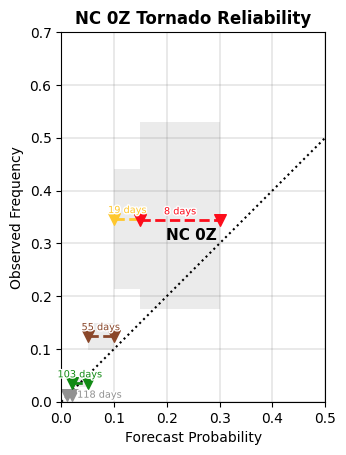

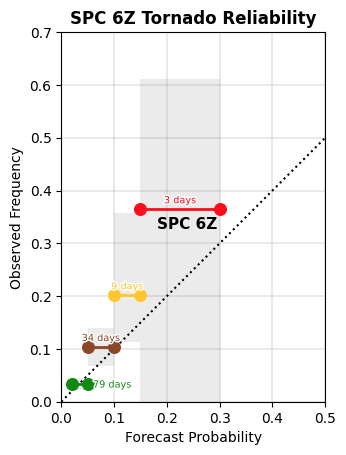

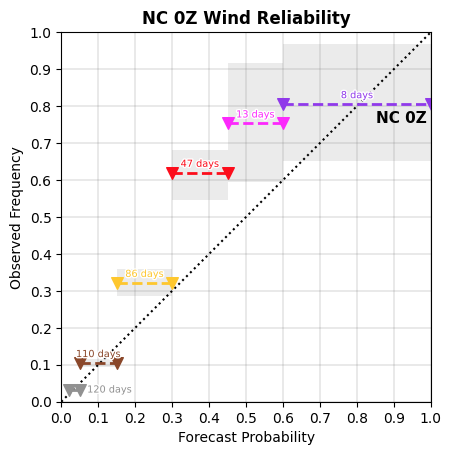

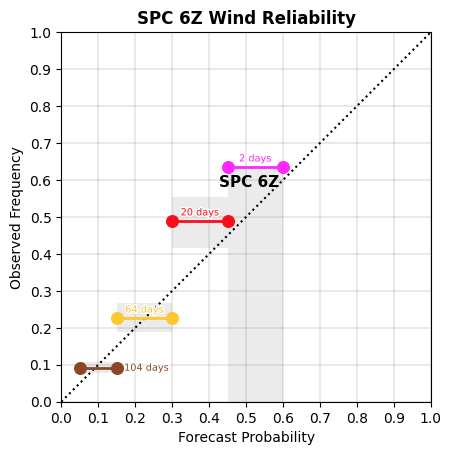

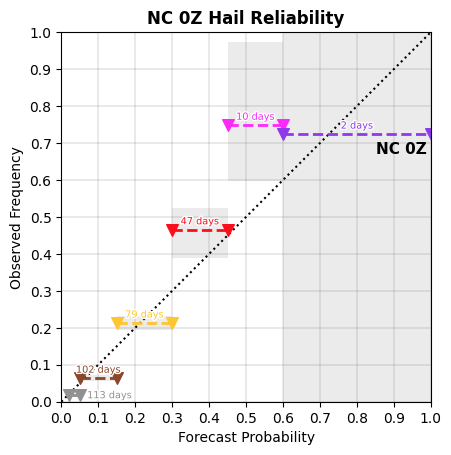

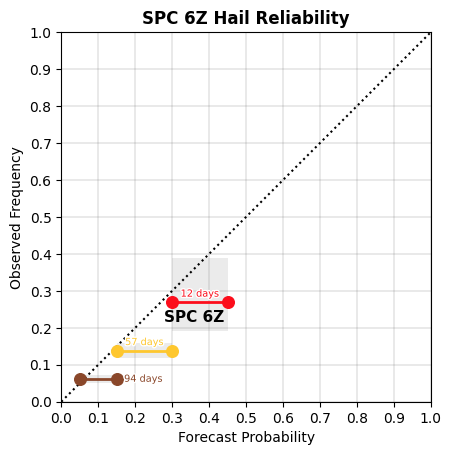

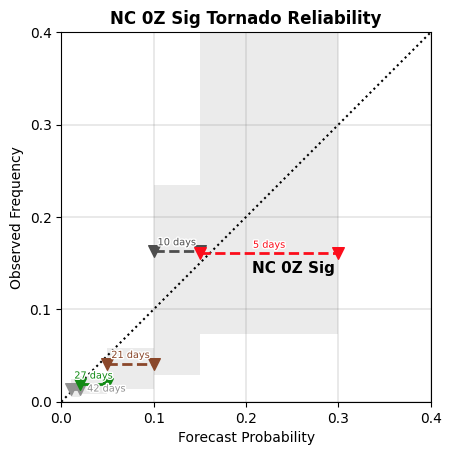

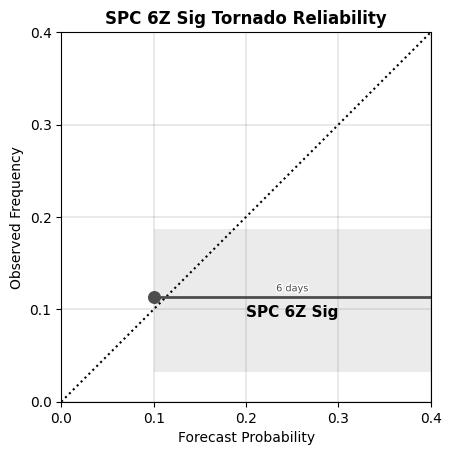

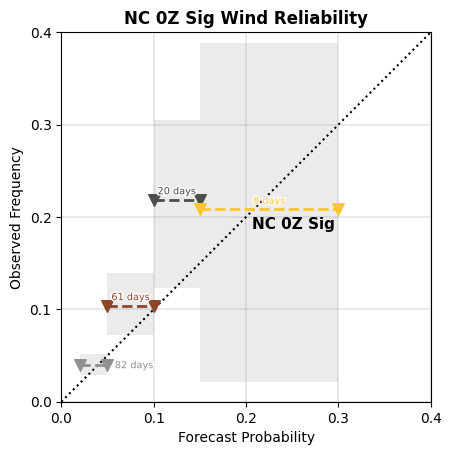

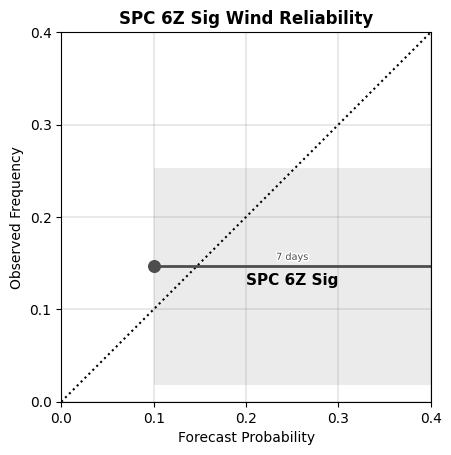

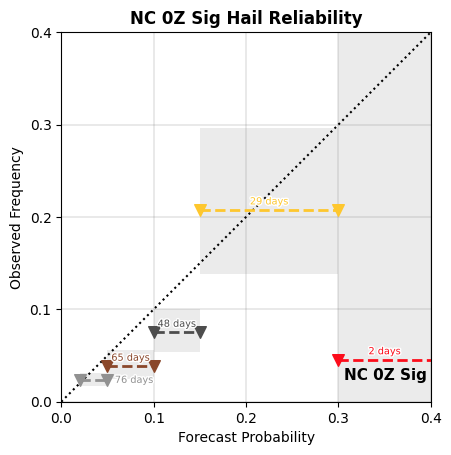

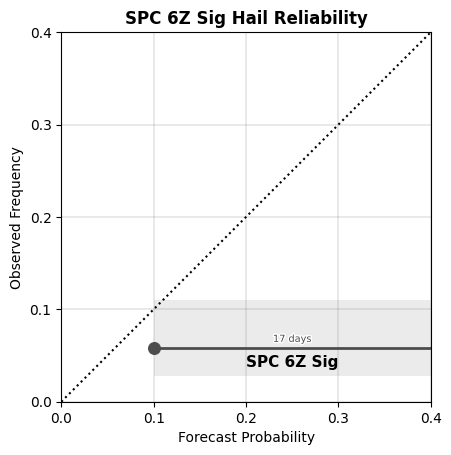

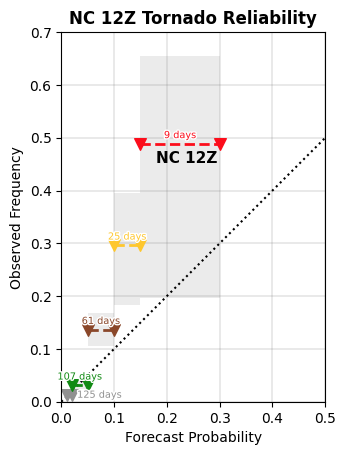

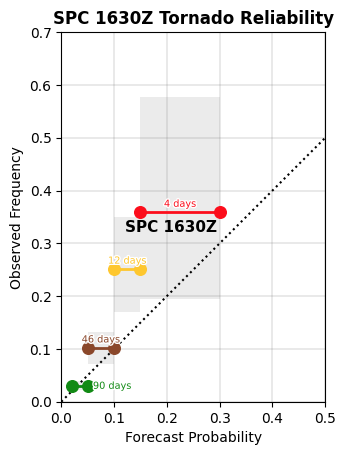

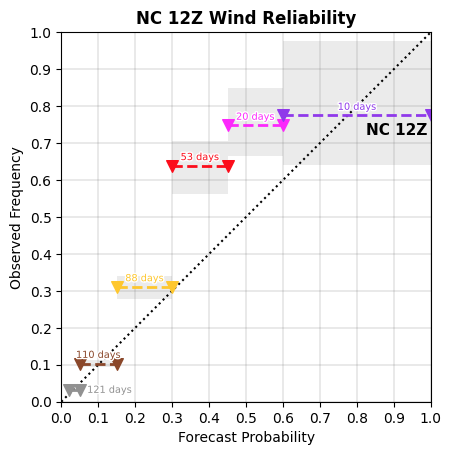

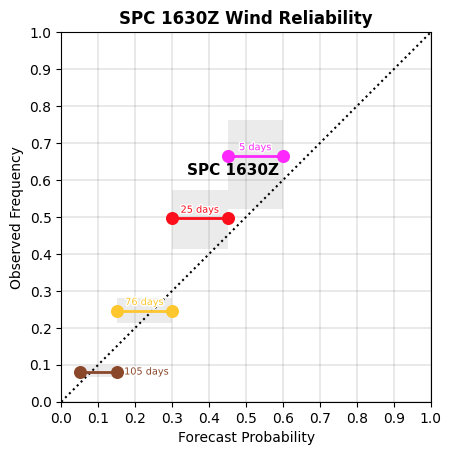

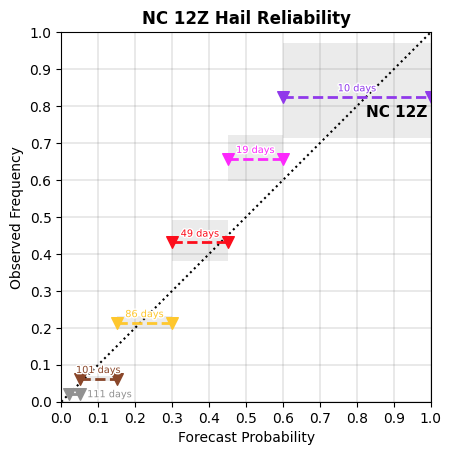

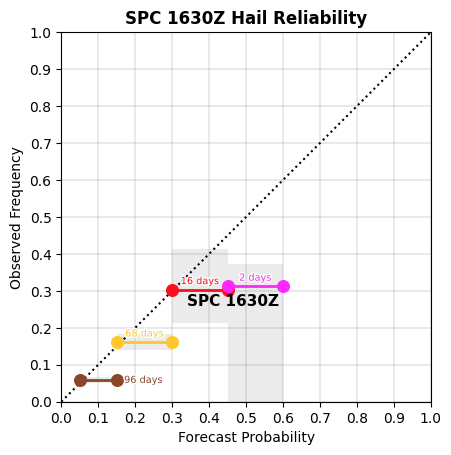

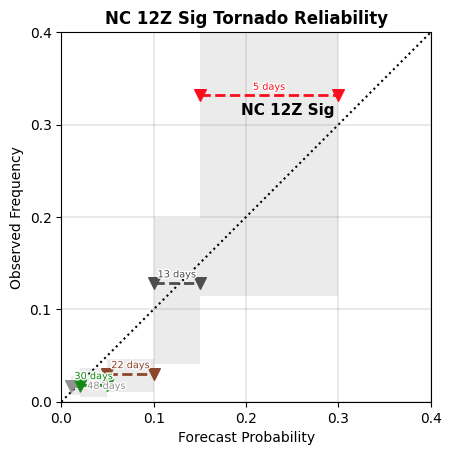

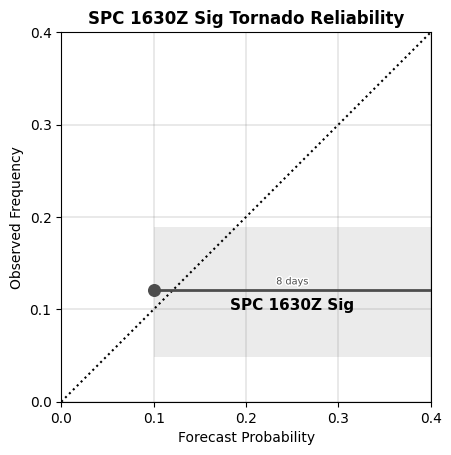

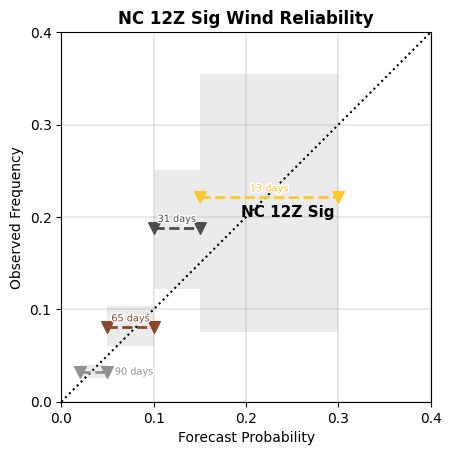

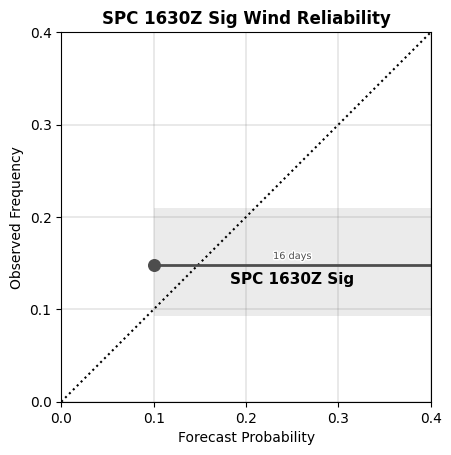

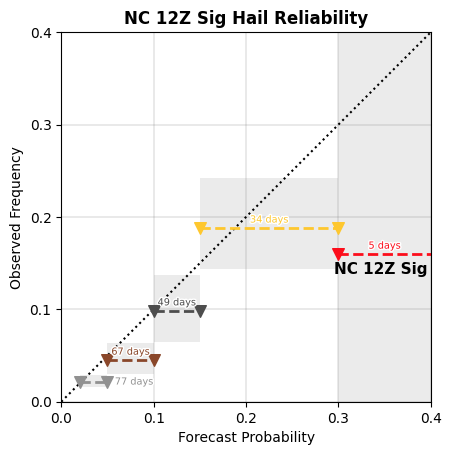

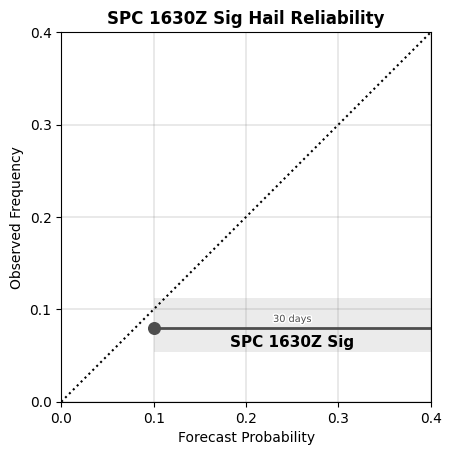

In [16]:
for suffix in suffixes:
    reliability_plot(f"test_reliability_0z{suffix}.csv", "NC 0Z", "nadocast", "Tornado", "tornado", tornado_colors, 0.5, 0.7, min_days=2)
    reliability_plot(f"test_reliability_0z{suffix}.csv", "SPC 6Z", "spc", "Tornado", "tornado", tornado_colors, 0.5, 0.7, min_days=2)
    reliability_plot(f"test_reliability_0z{suffix}.csv", "NC 0Z", "nadocast", "Wind", "wind", wind_hail_colors, 1, 1, min_days=2)
    reliability_plot(f"test_reliability_0z{suffix}.csv", "SPC 6Z", "spc", "Wind", "wind", wind_hail_colors, 1, 1, min_days=2)
    wind_adj and reliability_plot(f"test_reliability_0z{suffix}.csv", "NC 0Z", "nadocast", "Wind Adjusted", "wind_adj", wind_hail_colors, 1, 1, min_days=2)
    wind_adj and reliability_plot(f"test_reliability_0z{suffix}.csv", "SPC 6Z", "spc", "Wind Adjusted", "wind_adj", wind_hail_colors, 1, 1, min_days=2)
    reliability_plot(f"test_reliability_0z{suffix}.csv", "NC 0Z", "nadocast", "Hail", "hail", wind_hail_colors, 1, 1, min_days=2)
    reliability_plot(f"test_reliability_0z{suffix}.csv", "SPC 6Z", "spc", "Hail", "hail", wind_hail_colors, 1, 1, min_days=2)
    reliability_plot(f"test_reliability_0z{suffix}.csv", "NC 0Z Sig", "nadocast", "Tornado", "sig_tornado_gated_by_tornado", sig_tornado_more_colors, 0.4, 0.4, min_days=2)
    reliability_plot(f"test_reliability_0z{suffix}.csv", "SPC 6Z Sig", "spc", "Tornado", "sig_tornado", sig_tornado_more_colors, 0.4, 0.4, min_days=2)
    reliability_plot(f"test_reliability_0z{suffix}.csv", "NC 0Z Sig", "nadocast", "Wind", "sig_wind_gated_by_wind", sig_wind_hail_more_colors, 0.4, 0.4, min_days=2)
    reliability_plot(f"test_reliability_0z{suffix}.csv", "SPC 6Z Sig", "spc", "Wind", "sig_wind", sig_wind_hail_more_colors, 0.4, 0.4, min_days=2)
    wind_adj and reliability_plot(f"test_reliability_0z{suffix}.csv", "NC 0Z Sig", "nadocast", "Wind Adjusted", "sig_wind_adj_gated_by_wind_adj", sig_wind_hail_more_colors, 0.4, 0.4, min_days=2)
    wind_adj and reliability_plot(f"test_reliability_0z{suffix}.csv", "SPC 6Z Sig", "spc", "Wind Adjusted", "sig_wind_adj", sig_wind_hail_more_colors, 0.4, 0.4, min_days=2)
    reliability_plot(f"test_reliability_0z{suffix}.csv", "NC 0Z Sig", "nadocast", "Hail", "sig_hail_gated_by_hail", sig_wind_hail_more_colors, 0.4, 0.4, min_days=2)
    reliability_plot(f"test_reliability_0z{suffix}.csv", "SPC 6Z Sig", "spc", "Hail", "sig_hail", sig_wind_hail_more_colors, 0.4, 0.4, min_days=2)
    reliability_plot(f"test_reliability_12z{suffix}.csv", "NC 12Z", "nadocast", "Tornado", "tornado", tornado_colors, 0.5, 0.7, min_days=2)
    reliability_plot(f"test_reliability_12z{suffix}.csv", "SPC 1630Z", "spc", "Tornado", "tornado", tornado_colors, 0.5, 0.7, min_days=2)
    reliability_plot(f"test_reliability_12z{suffix}.csv", "NC 12Z", "nadocast", "Wind", "wind", wind_hail_colors, 1, 1, min_days=2)
    reliability_plot(f"test_reliability_12z{suffix}.csv", "SPC 1630Z", "spc", "Wind", "wind", wind_hail_colors, 1, 1, min_days=2)
    wind_adj and reliability_plot(f"test_reliability_12z{suffix}.csv", "NC 12Z", "nadocast", "Wind Adjusted", "wind_adj", wind_hail_colors, 1, 1, min_days=2)
    wind_adj and reliability_plot(f"test_reliability_12z{suffix}.csv", "SPC 1630Z", "spc", "Wind Adjusted", "wind_adj", wind_hail_colors, 1, 1, min_days=2)
    reliability_plot(f"test_reliability_12z{suffix}.csv", "NC 12Z", "nadocast", "Hail", "hail", wind_hail_colors, 1, 1, min_days=2)
    reliability_plot(f"test_reliability_12z{suffix}.csv", "SPC 1630Z", "spc", "Hail", "hail", wind_hail_colors, 1, 1, min_days=2)
    reliability_plot(f"test_reliability_12z{suffix}.csv", "NC 12Z Sig", "nadocast", "Tornado", "sig_tornado_gated_by_tornado", sig_tornado_more_colors, 0.4, 0.4, min_days=2)
    reliability_plot(f"test_reliability_12z{suffix}.csv", "SPC 1630Z Sig", "spc", "Tornado", "sig_tornado", sig_tornado_more_colors, 0.4, 0.4, min_days=2)
    reliability_plot(f"test_reliability_12z{suffix}.csv", "NC 12Z Sig", "nadocast", "Wind", "sig_wind_gated_by_wind", sig_wind_hail_more_colors, (0.4 if for_paper else 0.5), 0.4, min_days=2)
    reliability_plot(f"test_reliability_12z{suffix}.csv", "SPC 1630Z Sig", "spc", "Wind", "sig_wind", sig_wind_hail_more_colors, (0.4 if for_paper else 0.5), 0.4, min_days=2)
    wind_adj and reliability_plot(f"test_reliability_12z{suffix}.csv", "NC 12Z Sig", "nadocast", "Wind Adjusted", "sig_wind_adj_gated_by_wind_adj", sig_wind_hail_more_colors, 0.5, 0.4, min_days=2)
    wind_adj and reliability_plot(f"test_reliability_12z{suffix}.csv", "SPC 1630Z Sig", "spc", "Wind Adjusted", "sig_wind_adj", sig_wind_hail_more_colors, 0.5, 0.4, min_days=2)
    reliability_plot(f"test_reliability_12z{suffix}.csv", "NC 12Z Sig", "nadocast", "Hail", "sig_hail_gated_by_hail", sig_wind_hail_more_colors, 0.4, 0.4, min_days=2)
    reliability_plot(f"test_reliability_12z{suffix}.csv", "SPC 1630Z Sig", "spc", "Hail", "sig_hail", sig_wind_hail_more_colors, 0.4, 0.4, min_days=2)

In [14]:
def auc(xs, ys):
    area = 0.0
    for i in range(len(xs) - 1):
        w = abs(xs[i+1] - xs[i])
        lo = min(ys[i], ys[i+1])
        hi = max(ys[i], ys[i+1])
        area += lo*w + 0.5*w*(hi - lo)
    return area

def roc_plot(csv_path, nc_label, spc_label, nice_event, event, sig_event, event_colors, sig_event_colors, xmax, extra_csi_thresholds, nc_sig_label_position=None):
    suffix = (re.compile(r"_(\d+)z(_\w+)?\.csv").search(csv_path)[2] or "")

    full_df = pd.read_csv(root_in + csv_path)

    df = full_df[full_df["event"] == event].copy()
    if event == "tornado":
        df = df[df["threshold"] >= 0.02].copy()
    else:
        df = df[df["threshold"] >= 0.05].copy()
    df.index = range(len(df))
    df["spc_success_ratio"] = df["spc_success_ratio"].astype(float)
    df["spc_pod"]           = df["spc_pod"].astype(float)
    
    event_colors     = [lookup(threshold, event_colors)     for threshold in df["threshold"]]

    fig, ax = plt.subplots()

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xticks(np.arange(0.,1.01,0.1))
    ax.set_yticks(np.arange(0.,1.01,0.1))
    ax.set_aspect(1)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("POD")
    ax.grid(color=(.5,.5,.5), linestyle='-', linewidth=0.25)


    xmax = ax.get_xlim()[1]
    ymax = ax.get_ylim()[1]

    ax.set_title(f"{nice_event} ROC{titleize_suffix(suffix)}\n({df['days_count'][0]} Days, 2019/1-2022/5)", pad=15, fontdict={"fontweight":"bold"})
    # ax.set_aspect(1)
    
    # SPC
    spc_xs = [1, *df["spc_false_positive_rate"], 0]
    spc_ys = [1, *df["spc_pod"], 0]
    ax.plot(spc_xs, spc_ys, zorder=-1, c=(0,0,0), linewidth=1)
    ax.scatter(df["spc_false_positive_rate"], df["spc_pod"], s=30, marker="o", c=event_colors)

    # NC
    nc_xs = [1, *df["nadocast_false_positive_rate"], 0]
    nc_ys = [1, *df["nadocast_pod"], 0]
    ax.plot(nc_xs, nc_ys, zorder=-1, c=(0,0,0), linewidth=1, linestyle="--")
    ax.scatter("nadocast_false_positive_rate", "nadocast_pod", s=30, marker="v", c=event_colors, edgecolors=event_colors, linewidths=2, data=df)

    # Series labels
    x1, y1 = (spc_xs[1], spc_ys[1])
    x2, y2 = (spc_xs[0], spc_ys[0])
    spc_legend_rot = np.degrees(np.arctan2(y2 - y1, x2 - x1))
    spc_auc = auc(spc_xs, spc_ys)
    ax.text(0.66*spc_xs[1] + 0.34*spc_xs[0], 0.66*spc_ys[1] + 0.34*spc_ys[0] - 0.005*ymax, f"{spc_label} AUC = {spc_auc:.3f}", fontsize=12, horizontalalignment="center", va="top", fontweight="bold", rotation=spc_legend_rot, rotation_mode="anchor")

    x1, y1 = (nc_xs[1], nc_ys[1])
    x2, y2 = (nc_xs[0], nc_ys[0])
    nc_legend_rot = np.degrees(np.arctan2(y2 - y1, x2 - x1))
    nc_auc = auc(nc_xs, nc_ys)
    ax.text(0.66*nc_xs[1] + 0.34*nc_xs[0], 0.66*nc_ys[1] + 0.34*nc_ys[0], f"{nc_label} AUC = {nc_auc:.3f}",  fontsize=12, horizontalalignment="center", va="bottom", fontweight="bold", rotation=nc_legend_rot, rotation_mode="anchor")

    # (nadocast|spc_day_1)(_href_only|_href_ablations)?(_absolutely_calibrated)?_(tornado|wind|wind_adj|hail|sig_tornado|sig_wind|sig_wind_adj|sig_hail|tornado_\w+_\d+)(_gated_by_\w+)?_(\d{8})_t(\d+)z
    t_z    = (re.compile(r"_(\d+)z(_\w+)?\.csv").search(csv_path)[1] or "")
    t_z    = "00" if t_z == "0" else t_z
    out_path = f"{root_out}roc{suffix}_{event}_t{t_z}z.png"
    plt.savefig(out_path, dpi=200)
    os.system(f"oxipng -o max --strip safe --libdeflater {out_path}")
    plt.show()

Processing: plots_2021/roc_tornado_t00z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 102228 bytes
    File size = 102387 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 5        74306 bytes
    IDAT size = 74306 bytes (27922 bytes decrease)
    file size = 74384 bytes (28003 bytes = 27.35% decrease)
Output: plots_2021/roc_tornado_t00z.png


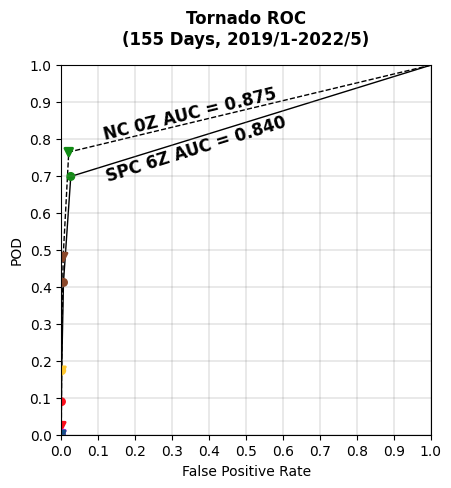

Processing: plots_2021/roc_wind_t00z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 100962 bytes
    File size = 101121 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 5        73590 bytes
    IDAT size = 73590 bytes (27372 bytes decrease)
    file size = 73668 bytes (27453 bytes = 27.15% decrease)
Output: plots_2021/roc_wind_t00z.png


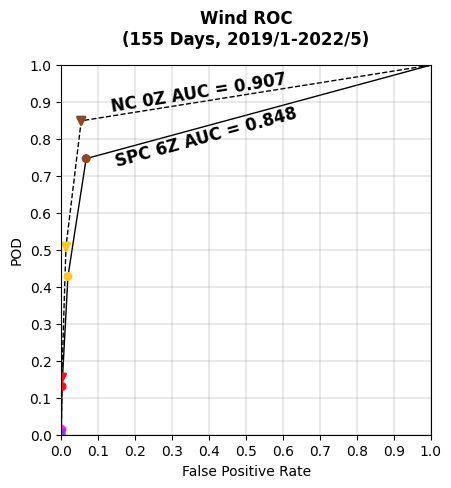

Processing: plots_2021/roc_hail_t00z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 99483 bytes
    File size = 99642 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 5        72297 bytes
    IDAT size = 72297 bytes (27186 bytes decrease)
    file size = 72375 bytes (27267 bytes = 27.36% decrease)
Output: plots_2021/roc_hail_t00z.png


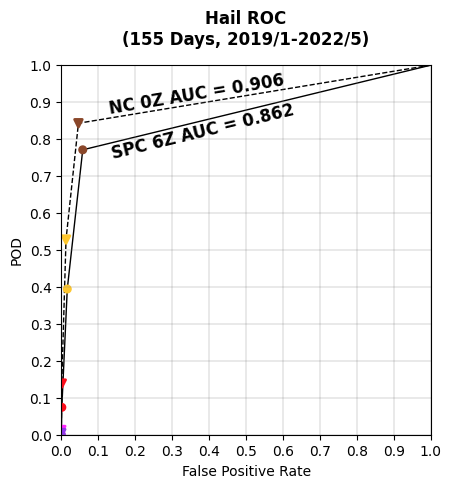

Processing: plots_2021/roc_tornado_t12z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 99405 bytes
    File size = 99564 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 5        70779 bytes
    IDAT size = 70779 bytes (28626 bytes decrease)
    file size = 70857 bytes (28707 bytes = 28.83% decrease)
Output: plots_2021/roc_tornado_t12z.png


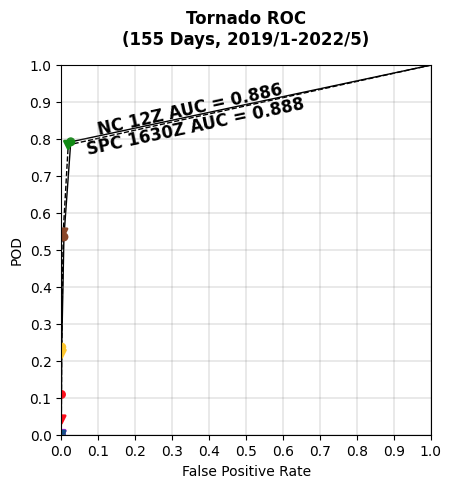

Processing: plots_2021/roc_wind_t12z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 101261 bytes
    File size = 101420 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 5        73218 bytes
    IDAT size = 73218 bytes (28043 bytes decrease)
    file size = 73296 bytes (28124 bytes = 27.73% decrease)
Output: plots_2021/roc_wind_t12z.png


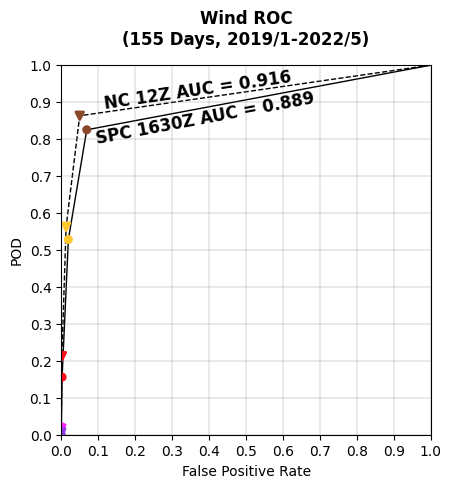

Processing: plots_2021/roc_hail_t12z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 99751 bytes
    File size = 99910 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 5        72076 bytes
    IDAT size = 72076 bytes (27675 bytes decrease)
    file size = 72154 bytes (27756 bytes = 27.78% decrease)
Output: plots_2021/roc_hail_t12z.png


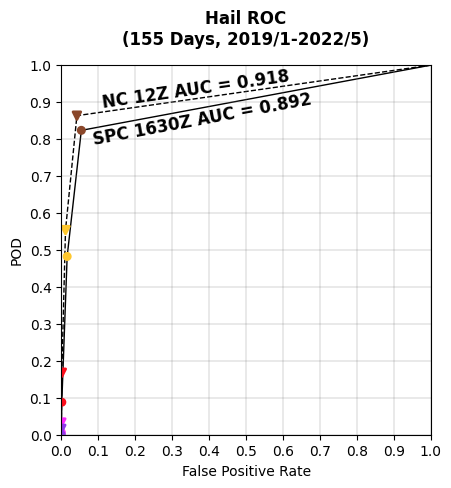

Processing: plots_2021/roc_absolutely_calibrated_tornado_t00z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 108775 bytes
    File size = 108934 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 5        78493 bytes
    IDAT size = 78493 bytes (30282 bytes decrease)
    file size = 78571 bytes (30363 bytes = 27.87% decrease)
Output: plots_2021/roc_absolutely_calibrated_tornado_t00z.png


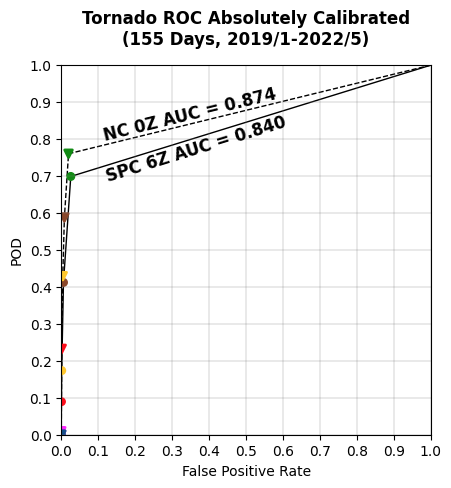

Processing: plots_2021/roc_absolutely_calibrated_wind_t00z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 107365 bytes
    File size = 107524 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 5        77748 bytes
    IDAT size = 77748 bytes (29617 bytes decrease)
    file size = 77826 bytes (29698 bytes = 27.62% decrease)
Output: plots_2021/roc_absolutely_calibrated_wind_t00z.png


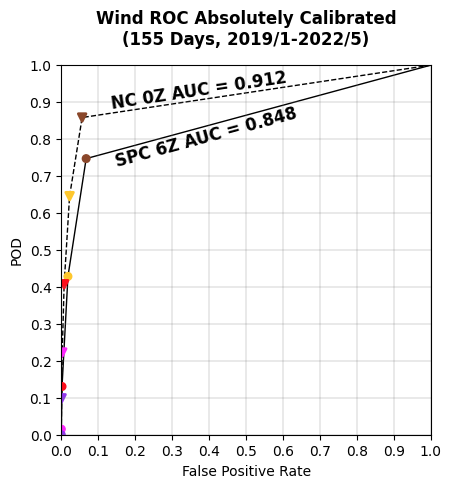

Processing: plots_2021/roc_absolutely_calibrated_hail_t00z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 102616 bytes
    File size = 102775 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 5        73812 bytes
    IDAT size = 73812 bytes (28804 bytes decrease)
    file size = 73890 bytes (28885 bytes = 28.11% decrease)
Output: plots_2021/roc_absolutely_calibrated_hail_t00z.png


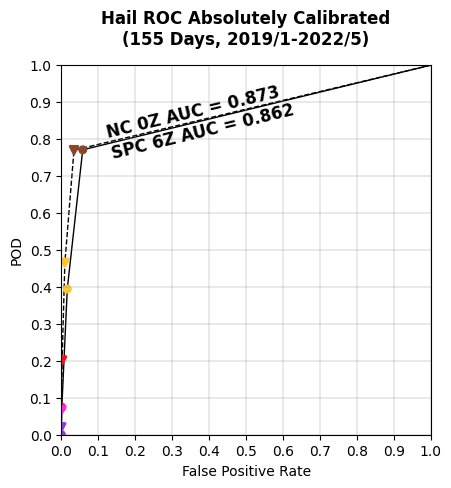

Processing: plots_2021/roc_absolutely_calibrated_tornado_t12z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 104906 bytes
    File size = 105065 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 5        74582 bytes
    IDAT size = 74582 bytes (30324 bytes decrease)
    file size = 74660 bytes (30405 bytes = 28.94% decrease)
Output: plots_2021/roc_absolutely_calibrated_tornado_t12z.png


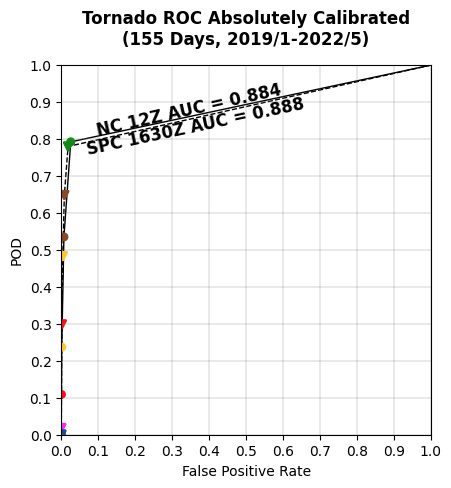

Processing: plots_2021/roc_absolutely_calibrated_wind_t12z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 107276 bytes
    File size = 107435 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 5        77207 bytes
    IDAT size = 77207 bytes (30069 bytes decrease)
    file size = 77285 bytes (30150 bytes = 28.06% decrease)
Output: plots_2021/roc_absolutely_calibrated_wind_t12z.png


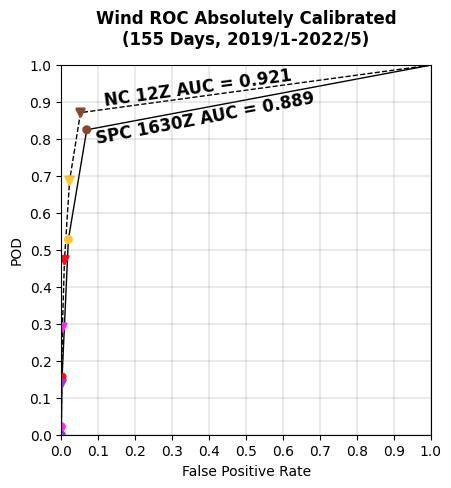

Processing: plots_2021/roc_absolutely_calibrated_hail_t12z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 103555 bytes
    File size = 103714 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 5        73877 bytes
    IDAT size = 73877 bytes (29678 bytes decrease)
    file size = 73955 bytes (29759 bytes = 28.69% decrease)
Output: plots_2021/roc_absolutely_calibrated_hail_t12z.png


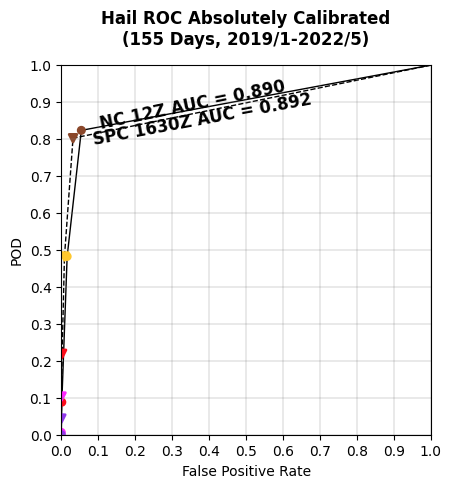

Processing: plots_2021/roc_href_only_tornado_t00z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 105221 bytes
    File size = 105380 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 5        76275 bytes
    IDAT size = 76275 bytes (28946 bytes decrease)
    file size = 76353 bytes (29027 bytes = 27.55% decrease)
Output: plots_2021/roc_href_only_tornado_t00z.png


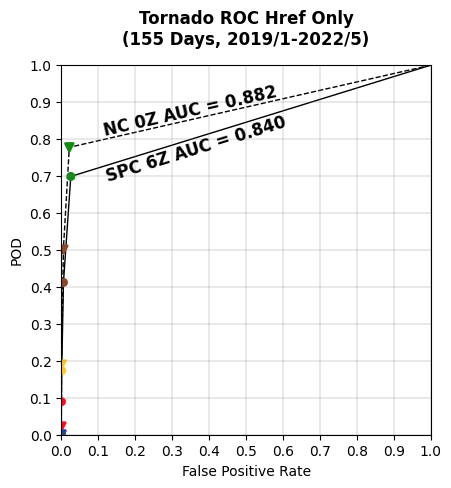

Processing: plots_2021/roc_href_only_wind_t00z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 103308 bytes
    File size = 103467 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 5        75087 bytes
    IDAT size = 75087 bytes (28221 bytes decrease)
    file size = 75165 bytes (28302 bytes = 27.35% decrease)
Output: plots_2021/roc_href_only_wind_t00z.png


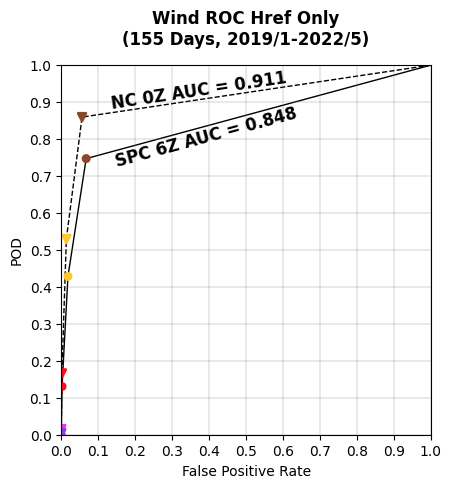

Processing: plots_2021/roc_href_only_hail_t00z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 101955 bytes
    File size = 102114 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 5        74173 bytes
    IDAT size = 74173 bytes (27782 bytes decrease)
    file size = 74251 bytes (27863 bytes = 27.29% decrease)
Output: plots_2021/roc_href_only_hail_t00z.png


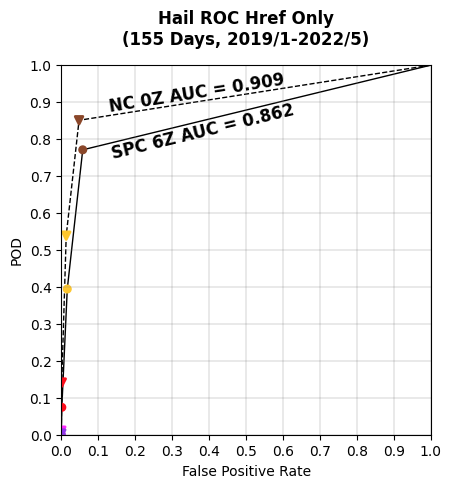

Processing: plots_2021/roc_href_only_tornado_t12z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 102881 bytes
    File size = 103040 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 5        73352 bytes
    IDAT size = 73352 bytes (29529 bytes decrease)
    file size = 73430 bytes (29610 bytes = 28.74% decrease)
Output: plots_2021/roc_href_only_tornado_t12z.png


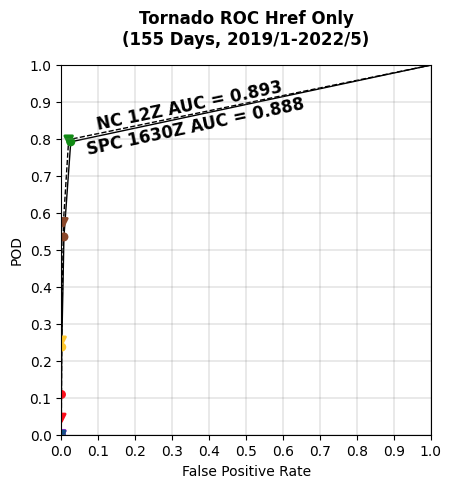

Processing: plots_2021/roc_href_only_wind_t12z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 103118 bytes
    File size = 103277 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 5        74454 bytes
    IDAT size = 74454 bytes (28664 bytes decrease)
    file size = 74532 bytes (28745 bytes = 27.83% decrease)
Output: plots_2021/roc_href_only_wind_t12z.png


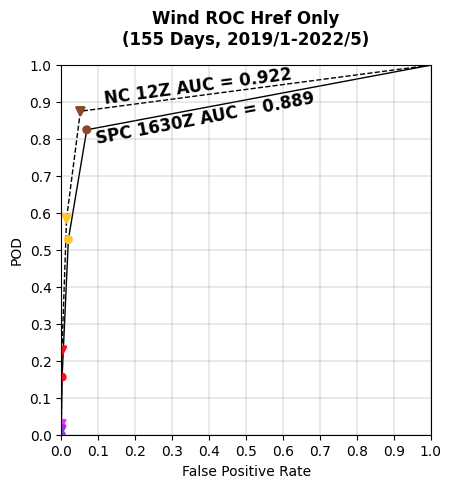

Processing: plots_2021/roc_href_only_hail_t12z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 102847 bytes
    File size = 103006 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 5        74162 bytes
    IDAT size = 74162 bytes (28685 bytes decrease)
    file size = 74240 bytes (28766 bytes = 27.93% decrease)
Output: plots_2021/roc_href_only_hail_t12z.png


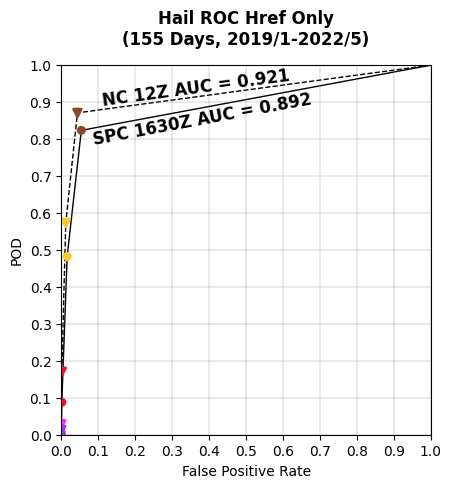

Processing: plots_2021/roc_href_only_absolutely_calibrated_tornado_t00z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 109952 bytes
    File size = 110111 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 5        79250 bytes
    IDAT size = 79250 bytes (30702 bytes decrease)
    file size = 79328 bytes (30783 bytes = 27.96% decrease)
Output: plots_2021/roc_href_only_absolutely_calibrated_tornado_t00z.png


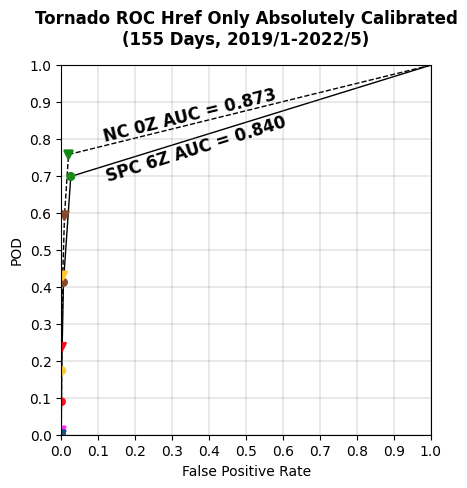

Processing: plots_2021/roc_href_only_absolutely_calibrated_wind_t00z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 108479 bytes
    File size = 108638 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 5        78716 bytes
    IDAT size = 78716 bytes (29763 bytes decrease)
    file size = 78794 bytes (29844 bytes = 27.47% decrease)
Output: plots_2021/roc_href_only_absolutely_calibrated_wind_t00z.png


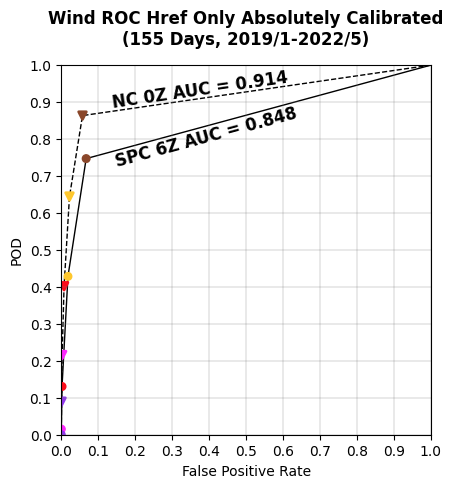

Processing: plots_2021/roc_href_only_absolutely_calibrated_hail_t00z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 103059 bytes
    File size = 103218 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 5        73694 bytes
    IDAT size = 73694 bytes (29365 bytes decrease)
    file size = 73772 bytes (29446 bytes = 28.53% decrease)
Output: plots_2021/roc_href_only_absolutely_calibrated_hail_t00z.png


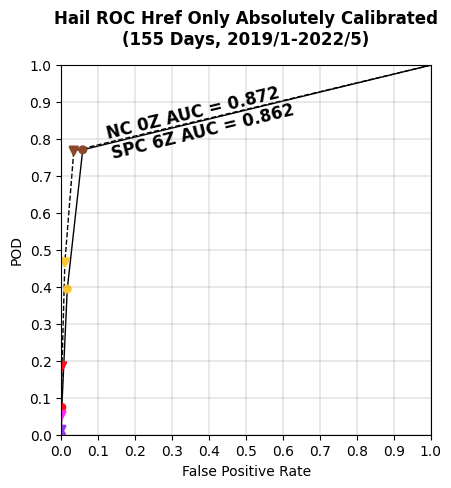

Processing: plots_2021/roc_href_only_absolutely_calibrated_tornado_t12z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 106629 bytes
    File size = 106788 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 5        75642 bytes
    IDAT size = 75642 bytes (30987 bytes decrease)
    file size = 75720 bytes (31068 bytes = 29.09% decrease)
Output: plots_2021/roc_href_only_absolutely_calibrated_tornado_t12z.png


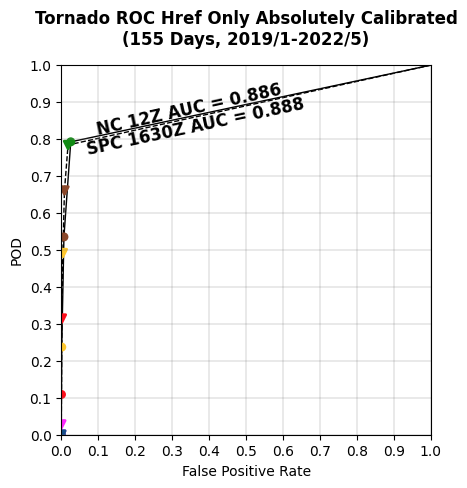

Processing: plots_2021/roc_href_only_absolutely_calibrated_wind_t12z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 108516 bytes
    File size = 108675 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 5        78197 bytes
    IDAT size = 78197 bytes (30319 bytes decrease)
    file size = 78275 bytes (30400 bytes = 27.97% decrease)
Output: plots_2021/roc_href_only_absolutely_calibrated_wind_t12z.png


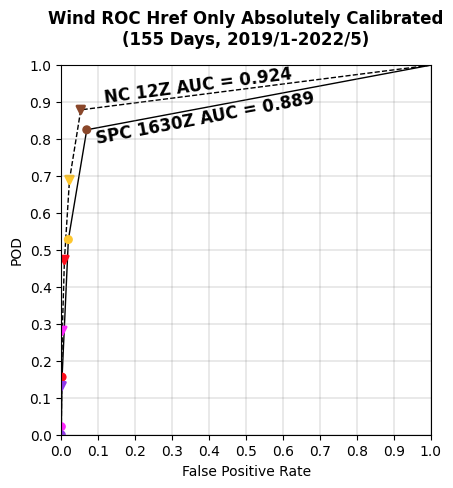

Processing: plots_2021/roc_href_only_absolutely_calibrated_hail_t12z.png
    1280x960 pixels, PNG format
    4x8 bits/pixel, RGBA
    IDAT size = 103872 bytes
    File size = 104031 bytes
Reducing image to 3x8 bits/pixel, RGB
Trying: 6 combinations
Found better combination:
    zc = 0  zs = 0  f = 5        73933 bytes
    IDAT size = 73933 bytes (29939 bytes decrease)
    file size = 74011 bytes (30020 bytes = 28.86% decrease)
Output: plots_2021/roc_href_only_absolutely_calibrated_hail_t12z.png


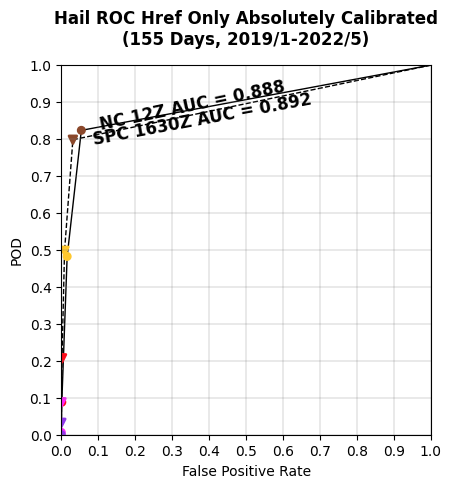

In [15]:
for suffix in suffixes:
    roc_plot(f"stats_0z{suffix}.csv", "NC 0Z", "SPC 6Z", "Tornado", "tornado", "sig_tornado_gated_by_tornado", tornado_colors, sig_tornado_more_colors, 0.4, [0.05, 0.15, 0.25, 0.35])
    roc_plot(f"stats_0z{suffix}.csv", "NC 0Z", "SPC 6Z", "Wind", "wind", "sig_wind_gated_by_wind", wind_hail_colors, sig_wind_hail_more_colors, 0.8, [0.05])
    wind_adj and roc_plot(f"stats_0z{suffix}.csv", "NC 0Z", "SPC 6Z", "Wind Adjusted", "wind_adj", "sig_wind_adj_gated_by_wind_adj", wind_hail_colors, sig_wind_hail_more_colors, 0.8, [0.05])
    roc_plot(f"stats_0z{suffix}.csv", "NC 0Z", "SPC 6Z", "Hail", "hail", "sig_hail_gated_by_hail", wind_hail_colors, sig_wind_hail_more_colors, 1, [0.05])
    roc_plot(f"stats_12z{suffix}.csv", "NC 12Z", "SPC 1630Z", "Tornado", "tornado", "sig_tornado_gated_by_tornado", tornado_colors, sig_tornado_more_colors, 0.4, [0.05, 0.15, 0.25, 0.35])
    roc_plot(f"stats_12z{suffix}.csv", "NC 12Z", "SPC 1630Z", "Wind", "wind", "sig_wind_gated_by_wind", wind_hail_colors, sig_wind_hail_more_colors, 0.8, [0.05])
    wind_adj and roc_plot(f"stats_12z{suffix}.csv", "NC 12Z", "SPC 1630Z", "Wind Adjusted", "wind_adj", "sig_wind_adj_gated_by_wind_adj", wind_hail_colors, sig_wind_hail_more_colors, 0.8, [0.05])
    roc_plot(f"stats_12z{suffix}.csv", "NC 12Z", "SPC 1630Z", "Hail", "hail", "sig_hail_gated_by_hail", wind_hail_colors, sig_wind_hail_more_colors, 1, [0.05])

In [16]:
a, b = 2, 3

In [2]:
b

NameError: name 'b' is not defined

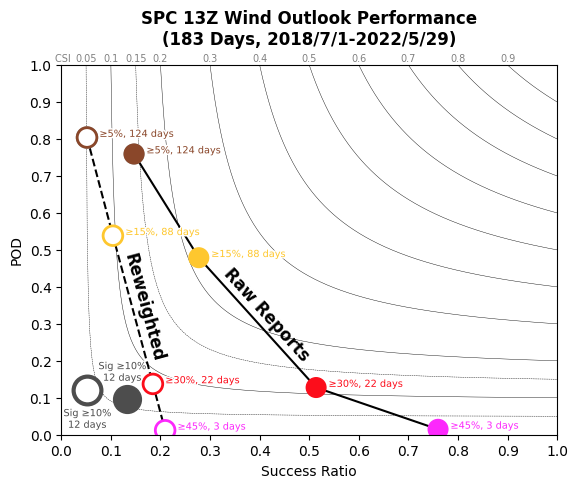

In [99]:
csv_path = "stats_12z_href_only_more_days_vs_13Z_spc.csv"

suffix = (re.compile(r"_(\d+)z(_\w+)?\.csv").search(csv_path)[2] or "")

full_df = pd.read_csv(root_in + csv_path)

df_wind = full_df[full_df["event"] == "wind"].copy()
df_wind.index = range(len(df_wind))
df_wind["spc_success_ratio"] = df_wind["spc_success_ratio"].astype(float)
df_wind["spc_pod"]           = df_wind["spc_pod"].astype(float)


df_wind_adj = full_df[full_df["event"] == "wind_adj"].copy()
df_wind_adj.index = range(len(df_wind_adj))
df_wind_adj["spc_success_ratio"] = df_wind_adj["spc_success_ratio"].astype(float)
df_wind_adj["spc_pod"]           = df_wind_adj["spc_pod"].astype(float)


sig_df_wind = full_df[full_df["event"] == "sig_wind"].copy()
sig_df_wind = sig_df_wind[sig_df_wind["threshold"] == 0.1].copy()
sig_df_wind.index = range(len(sig_df_wind))
sig_df_wind["spc_success_ratio"] = sig_df_wind["spc_success_ratio"].astype(float)
sig_df_wind["spc_pod"]           = sig_df_wind["spc_pod"].astype(float)

sig_df_wind_adj = full_df[full_df["event"] == "sig_wind_adj"].copy()
sig_df_wind_adj = sig_df_wind_adj[sig_df_wind_adj["threshold"] == 0.1].copy()
sig_df_wind_adj.index = range(len(sig_df_wind_adj))
sig_df_wind_adj["spc_success_ratio"] = sig_df_wind_adj["spc_success_ratio"].astype(float)
sig_df_wind_adj["spc_pod"]           = sig_df_wind_adj["spc_pod"].astype(float)

event_colors     = [lookup(threshold, wind_hail_colors) for threshold in df_wind["threshold"]]
sig_event_colors = [lookup(threshold, sig_colors)       for threshold in sig_df_wind["threshold"]]

fig, ax = plt.subplots()

ax.set_xlim(0,1)
ax.set_ylim(0,1)
xmax = ax.get_xlim()[1]
ymax = ax.get_ylim()[1]
ax.set_xticks(np.arange(0.,xmax + .01,0.1))
ax.set_yticks(np.arange(0.,ymax + .01,0.1))
ax.set_xlabel("Success Ratio")
ax.set_ylabel("POD")

ax.set_title(f"SPC 13Z Wind Outlook Performance\n({df_wind['days_count'][0]} Days, 2018/7/1-2022/5/29)", pad=15, fontdict={"fontweight":"bold"})
# ax.set_aspect(1)

# SPC
ax.plot("spc_success_ratio", "spc_pod", zorder=-1, c=(0,0,0), linewidth=1.5, data=df_wind)
ax.scatter("spc_success_ratio", "spc_pod", s=200, marker="o", c=event_colors, data=df_wind)

ax.plot("spc_success_ratio", "spc_pod", zorder=-1, c=(0,0,0), linewidth=1.5, data=df_wind_adj, linestyle="--")
ax.scatter("spc_success_ratio", "spc_pod", s=200, marker="o", color="white", edgecolors=event_colors, linewidths=2, data=df_wind_adj)

# SPC Sig
ax.scatter("spc_success_ratio", "spc_pod", s=400, marker="o", c=sig_event_colors, data=sig_df_wind)
ax.scatter("spc_success_ratio", "spc_pod", s=400, marker="o", c="white", edgecolors=sig_event_colors, linewidths=3, data=sig_df_wind_adj)

# Series labels
x1, y1 = ax.transData.transform((df_wind["spc_success_ratio"][2], df_wind["spc_pod"][2]))
x2, y2 = ax.transData.transform((df_wind["spc_success_ratio"][3], df_wind["spc_pod"][3]))
spc_legend_rot = np.degrees(np.arctan2(y2 - y1, x2 - x1))
ax.text(0.5*df_wind["spc_success_ratio"][2] + 0.5*df_wind["spc_success_ratio"][3], 0.5*df_wind["spc_pod"][2] + 0.5*df_wind["spc_pod"][3], "Raw Reports\n", fontsize=12, horizontalalignment="center", va="bottom", fontweight="bold", rotation=spc_legend_rot, rotation_mode="anchor", linespacing=-0.1)

x1, y1 = ax.transData.transform((df_wind_adj["spc_success_ratio"][2], df_wind_adj["spc_pod"][2]))
x2, y2 = ax.transData.transform((df_wind_adj["spc_success_ratio"][3], df_wind_adj["spc_pod"][3]))
spc_legend_rot = np.degrees(np.arctan2(y2 - y1, x2 - x1))
ax.text(0.5*df_wind_adj["spc_success_ratio"][2] + 0.5*df_wind_adj["spc_success_ratio"][3], 0.5*df_wind_adj["spc_pod"][2] + 0.5*df_wind_adj["spc_pod"][3], "Reweighted\n", fontsize=12, horizontalalignment="center", va="bottom", fontweight="bold", rotation=spc_legend_rot, rotation_mode="anchor", linespacing=-0.1)

white_outline = [pe.withStroke(linewidth=2, foreground=(1,1,1))]

# # NC symbol labels
# for i in range(len(df["threshold"])):
#     ndays = df["nadocast_threshold_days"][i]
#     x = df["nadocast_success_ratio"][i]
#     y = df["nadocast_pod"][i]
#     if ndays <= 1: continue
#     if np.isnan(x): continue
#     if np.isnan(y): continue
#     p = df["p_value_nadocast_csi_better"][i]
#     p_str = f"\n{p_value(p)}" if (i+1 == len(df) or df["spc_pod"][i] != df["spc_pod"][i+1]) and df["spc_threshold_days"][i] >= 1 else ""
#     if x < 0.92*xmax:
#         ax.text(x + 0.03*xmax, y + 0.01*ymax, f"{ndays} days{p_str}", fontsize=7, horizontalalignment="left", c=event_colors[i], path_effects=white_outline)
#     else:
#         ax.text(x - 0.03*xmax, y + 0.01*ymax, f"{ndays} days{p_str}", fontsize=7, horizontalalignment="right", c=event_colors[i], path_effects=white_outline)

# SPC symbol labels
for i in range(len(df_wind["threshold"])):
    threshold = df_wind["threshold"][i]
    ndays = df_wind["spc_threshold_days"][i]
    x = df_wind["spc_success_ratio"][i]
    y = df_wind["spc_pod"][i]
    if np.isnan(x): continue
    if np.isnan(y): continue
    if y > 0.01*ymax:
        ax.text(x + 0.025*xmax, y + 0.01*ymax, f"≥{int(threshold*100)}%, {ndays} days", fontsize=7, horizontalalignment="left", va="center", c=event_colors[i], path_effects=white_outline)
    else:
        ax.text(x, y + 0.035*ymax, f"≥{int(threshold*100)}%, {ndays} days", fontsize=7, horizontalalignment="center", va="bottom", c=event_colors[i], path_effects=white_outline)

for i in range(len(df_wind_adj["threshold"])):
    threshold = df_wind_adj["threshold"][i]
    ndays = df_wind_adj["spc_threshold_days"][i]
    x = df_wind_adj["spc_success_ratio"][i]
    y = df_wind_adj["spc_pod"][i]
    if np.isnan(x): continue
    if np.isnan(y): continue
    if y > 0.01*ymax:
        ax.text(x + 0.025*xmax, y + 0.01*ymax, f"≥{int(threshold*100)}%, {ndays} days", fontsize=7, horizontalalignment="left", va="center", c=event_colors[i], path_effects=white_outline)
    else:
        ax.text(x, y + 0.035*ymax, f"≥{int(threshold*100)}%, {ndays} days", fontsize=7, horizontalalignment="center", va="bottom", c=event_colors[i], path_effects=white_outline)

        
# # NC sig symbol labels
# for i in range(len(sig_df["threshold"])):
#     ndays = sig_df["nadocast_threshold_days"][i]
#     x = sig_df["nadocast_success_ratio"][i]
#     y = sig_df["nadocast_pod"][i]
#     if np.isnan(x): continue
#     if np.isnan(y): continue
#     p = sig_df["p_value_nadocast_csi_better"][i]
#     if nc_sig_label_position == "right":
#         ax.text(x + 0.04*xmax, y, f"NC Sig Bounded\n{ndays} days\n{p_value(p)}", fontsize=7, horizontalalignment="left", va="center", c=sig_event_colors[i], path_effects=white_outline)
#     elif y > 0.15*ymax:
#         ax.text(x, y - 0.05*ymax, f"NC Sig Bounded\n{ndays} days\n{p_value(p)}", fontsize=7, horizontalalignment="center", va="top", c=sig_event_colors[i], path_effects=white_outline)
#     else:
#         ax.text(x, y + 0.05*ymax, f"NC Sig Bounded\n{ndays} days\n{p_value(p)}", fontsize=7, horizontalalignment="center", va="bottom", c=sig_event_colors[i], path_effects=white_outline)


# SPC sig symbol labels
for i in range(len(sig_df_wind["threshold"])):
    threshold = sig_df_wind["threshold"][i]
    ndays = sig_df_wind["spc_threshold_days"][i]
    x = sig_df_wind["spc_success_ratio"][i]
    y = sig_df_wind["spc_pod"][i]
    if np.isnan(x): continue
    if np.isnan(y): continue
    if y > 0.12*ymax:
        ax.text(x, y - 0.05*ymax, f"Sig ≥{int(threshold*100)}%\n{ndays} days", fontsize=7, horizontalalignment="center", va="top", c=sig_event_colors[i], path_effects=white_outline)
    else:
        ax.text(x - 0.01*xmax, y + 0.045*ymax, f"Sig ≥{int(threshold*100)}%\n{ndays} days", fontsize=7, horizontalalignment="center", va="bottom", c=sig_event_colors[i], path_effects=white_outline)

for i in range(len(sig_df_wind_adj["threshold"])):
    threshold = sig_df_wind_adj["threshold"][i]
    ndays = sig_df_wind_adj["spc_threshold_days"][i]
    x = sig_df_wind_adj["spc_success_ratio"][i]
    y = sig_df_wind_adj["spc_pod"][i]
    if np.isnan(x): continue
    if np.isnan(y): continue
    if y > 0.12*ymax:
        ax.text(x, y - 0.05*ymax, f"Sig ≥{int(threshold*100)}%\n{ndays} days", fontsize=7, horizontalalignment="center", va="top", c=sig_event_colors[i], path_effects=white_outline)
    else:
        ax.text(x - 0.01*xmax, y + 0.045*ymax, f"Sig ≥{int(threshold*100)}%\n{ndays} days", fontsize=7, horizontalalignment="center", va="bottom", c=sig_event_colors[i], path_effects=white_outline)


# CSI 0.1 0.2 0.3 etc lines
# cribbed from verif package
ax.text(0.05, ymax + .01, "CSI     ", fontsize=7, horizontalalignment="right", c=(.5,.5,.5))
threats = np.around(np.arange(0.1,xmax-.01,0.1), 1)
for i in range(len(threats)):
    threat = threats[i]
    x = np.linspace(threat, 1, 400)
    label = ""
    if i == 0:
        label = "Threat score"
    y = 1.0 / (1 + 1.0/threat - 1.0 / x)
    label_x = -1.0 / (1.0/ymax - 1 - 1.0/threat)
    ax.plot(x, y, 'k-', zorder=-1, linewidth=0.3, label=label)
    ax.text(label_x, ymax + .01, str(threat), fontsize=7, horizontalalignment="center", c=(.5,.5,.5))

# CSI 0.05 0.15 0.25 etc lines
threats = [0.05, 0.15]
for i in range(len(threats)):
    threat = threats[i]
    x = np.linspace(threat, 1, 400)
    y = 1.0 / (1 + 1.0/threat - 1.0 / x)
    label_x = -1.0 / (1.0/ymax - 1 - 1.0/threat)    
    ax.plot(x, y, 'k--', zorder=-1, linewidth=0.3)
    ax.text(label_x, ymax + .01, str(threat), fontsize=7, horizontalalignment="center", c=(.5,.5,.5))

# (nadocast|spc_day_1)(_href_only|_href_ablations)?(_absolutely_calibrated)?_(tornado|wind|wind_adj|hail|sig_tornado|sig_wind|sig_wind_adj|sig_hail|tornado_\w+_\d+)(_gated_by_\w+)?_(\d{8})_t(\d+)z
# t_z    = (re.compile(r"_(\d+)z(_\w+)?\.csv").search(csv_path)[1] or "")
# t_z    = "00" if t_z == "0" else t_z
out_path = f"spc_13z_wind_outlook_performance_{df_wind['days_count'][0]}_days.pdf"
plt.savefig(out_path, dpi=200)
# os.system(f"oxipng -o max --strip safe --libdeflater {out_path}")
plt.show()

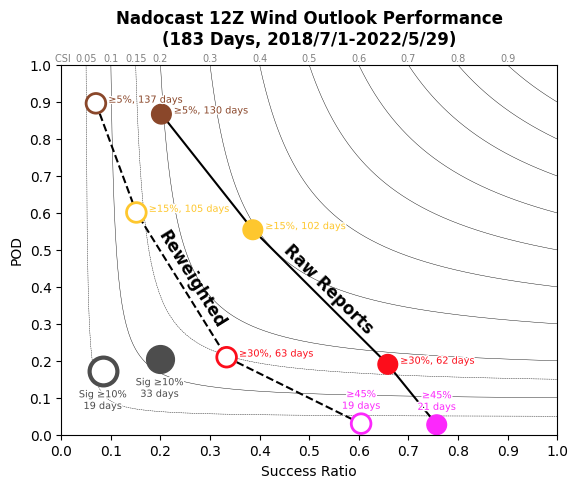

In [100]:
csv_path = "stats_12z_href_only_more_days_vs_13Z_spc.csv"

suffix = (re.compile(r"_(\d+)z(_\w+)?\.csv").search(csv_path)[2] or "")

full_df = pd.read_csv(root_in + csv_path)

df_wind = full_df[(full_df["event"] == "wind") & (full_df["threshold"] >= 0.05) & (full_df["threshold"] <= 0.45)].copy()
df_wind.index = range(len(df_wind))
df_wind["nadocast_success_ratio"] = df_wind["nadocast_success_ratio"].astype(float)
df_wind["nadocast_pod"]           = df_wind["nadocast_pod"].astype(float)


df_wind_adj = full_df[(full_df["event"] == "wind_adj") & (full_df["threshold"] >= 0.05) & (full_df["threshold"] <= 0.45)].copy()
df_wind_adj.index = range(len(df_wind_adj))
df_wind_adj["nadocast_success_ratio"] = df_wind_adj["nadocast_success_ratio"].astype(float)
df_wind_adj["nadocast_pod"]           = df_wind_adj["nadocast_pod"].astype(float)


sig_df_wind = full_df[full_df["event"] == "sig_wind"].copy()
sig_df_wind = sig_df_wind[sig_df_wind["threshold"] == 0.1].copy()
sig_df_wind.index = range(len(sig_df_wind))
sig_df_wind["nadocast_success_ratio"] = sig_df_wind["nadocast_success_ratio"].astype(float)
sig_df_wind["nadocast_pod"]           = sig_df_wind["nadocast_pod"].astype(float)

sig_df_wind_adj = full_df[full_df["event"] == "sig_wind_adj"].copy()
sig_df_wind_adj = sig_df_wind_adj[sig_df_wind_adj["threshold"] == 0.1].copy()
sig_df_wind_adj.index = range(len(sig_df_wind_adj))
sig_df_wind_adj["nadocast_success_ratio"] = sig_df_wind_adj["nadocast_success_ratio"].astype(float)
sig_df_wind_adj["nadocast_pod"]           = sig_df_wind_adj["nadocast_pod"].astype(float)

event_colors     = [lookup(threshold, wind_hail_colors) for threshold in df_wind["threshold"]]
sig_event_colors = [lookup(threshold, sig_colors)       for threshold in sig_df_wind["threshold"]]

fig, ax = plt.subplots()

ax.set_xlim(0,1)
ax.set_ylim(0,1)
xmax = ax.get_xlim()[1]
ymax = ax.get_ylim()[1]
ax.set_xticks(np.arange(0.,xmax + .01,0.1))
ax.set_yticks(np.arange(0.,ymax + .01,0.1))
ax.set_xlabel("Success Ratio")
ax.set_ylabel("POD")

ax.set_title(f"Nadocast 12Z Wind Outlook Performance\n({df_wind['days_count'][0]} Days, 2018/7/1-2022/5/29)", pad=15, fontdict={"fontweight":"bold"})
# ax.set_aspect(1)

# SPC
ax.plot("nadocast_success_ratio", "nadocast_pod", zorder=-1, c=(0,0,0), linewidth=1.5, data=df_wind)
ax.scatter("nadocast_success_ratio", "nadocast_pod", s=200, marker="o", c=event_colors, data=df_wind)

ax.plot("nadocast_success_ratio", "nadocast_pod", zorder=-1, c=(0,0,0), linewidth=1.5, data=df_wind_adj, linestyle="--")
ax.scatter("nadocast_success_ratio", "nadocast_pod", s=200, marker="o", color="white", edgecolors=event_colors, linewidths=2, data=df_wind_adj)

# SPC Sig
ax.scatter("nadocast_success_ratio", "nadocast_pod", s=400, marker="o", c=sig_event_colors, data=sig_df_wind)
ax.scatter("nadocast_success_ratio", "nadocast_pod", s=400, marker="o", c="white", edgecolors=sig_event_colors, linewidths=3, data=sig_df_wind_adj)

# Series labels
x1, y1 = ax.transData.transform((df_wind["nadocast_success_ratio"][1], df_wind["nadocast_pod"][1]))
x2, y2 = ax.transData.transform((df_wind["nadocast_success_ratio"][2], df_wind["nadocast_pod"][2]))
nadocast_legend_rot = np.degrees(np.arctan2(y2 - y1, x2 - x1))
ax.text(0.5*df_wind["nadocast_success_ratio"][1] + 0.5*df_wind["nadocast_success_ratio"][2], 0.5*df_wind["nadocast_pod"][1] + 0.5*df_wind["nadocast_pod"][2], "Raw Reports\n", fontsize=12, horizontalalignment="center", va="bottom", fontweight="bold", rotation=nadocast_legend_rot, rotation_mode="anchor", linespacing=-0.1)

x1, y1 = ax.transData.transform((df_wind_adj["nadocast_success_ratio"][1], df_wind_adj["nadocast_pod"][1]))
x2, y2 = ax.transData.transform((df_wind_adj["nadocast_success_ratio"][2], df_wind_adj["nadocast_pod"][2]))
nadocast_legend_rot = np.degrees(np.arctan2(y2 - y1, x2 - x1))
ax.text(0.5*df_wind_adj["nadocast_success_ratio"][1] + 0.5*df_wind_adj["nadocast_success_ratio"][2], 0.5*df_wind_adj["nadocast_pod"][1] + 0.5*df_wind_adj["nadocast_pod"][2], "Reweighted\n", fontsize=12, horizontalalignment="center", va="bottom", fontweight="bold", rotation=nadocast_legend_rot, rotation_mode="anchor", linespacing=-0.1)

white_outline = [pe.withStroke(linewidth=2, foreground=(1,1,1))]

# # NC symbol labels
# for i in range(len(df["threshold"])):
#     ndays = df["nadocast_threshold_days"][i]
#     x = df["nadocast_success_ratio"][i]
#     y = df["nadocast_pod"][i]
#     if ndays <= 1: continue
#     if np.isnan(x): continue
#     if np.isnan(y): continue
#     p = df["p_value_nadocast_csi_better"][i]
#     p_str = f"\n{p_value(p)}" if (i+1 == len(df) or df["nadocast_pod"][i] != df["nadocast_pod"][i+1]) and df["nadocast_threshold_days"][i] >= 1 else ""
#     if x < 0.92*xmax:
#         ax.text(x + 0.03*xmax, y + 0.01*ymax, f"{ndays} days{p_str}", fontsize=7, horizontalalignment="left", c=event_colors[i], path_effects=white_outline)
#     else:
#         ax.text(x - 0.03*xmax, y + 0.01*ymax, f"{ndays} days{p_str}", fontsize=7, horizontalalignment="right", c=event_colors[i], path_effects=white_outline)

# SPC symbol labels
for i in range(len(df_wind["threshold"])):
    threshold = df_wind["threshold"][i]
    ndays = df_wind["nadocast_threshold_days"][i]
    x = df_wind["nadocast_success_ratio"][i]
    y = df_wind["nadocast_pod"][i]
    if np.isnan(x): continue
    if np.isnan(y): continue
    if y > 0.04*ymax:
        ax.text(x + 0.025*xmax, y + 0.01*ymax, f"≥{int(threshold*100)}%, {ndays} days", fontsize=7, horizontalalignment="left", va="center", c=event_colors[i], path_effects=white_outline)
    else:
        ax.text(x, y + 0.035*ymax, f"≥{int(threshold*100)}%\n{ndays} days", fontsize=7, horizontalalignment="center", va="bottom", c=event_colors[i], path_effects=white_outline)

for i in range(len(df_wind_adj["threshold"])):
    threshold = df_wind_adj["threshold"][i]
    ndays = df_wind_adj["nadocast_threshold_days"][i]
    x = df_wind_adj["nadocast_success_ratio"][i]
    y = df_wind_adj["nadocast_pod"][i]
    if np.isnan(x): continue
    if np.isnan(y): continue
    if y > 0.04*ymax:
        ax.text(x + 0.025*xmax, y + 0.01*ymax, f"≥{int(threshold*100)}%, {ndays} days", fontsize=7, horizontalalignment="left", va="center", c=event_colors[i], path_effects=white_outline)
    else:
        ax.text(x, y + 0.035*ymax, f"≥{int(threshold*100)}%\n{ndays} days", fontsize=7, horizontalalignment="center", va="bottom", c=event_colors[i], path_effects=white_outline)

        
# # NC sig symbol labels
# for i in range(len(sig_df["threshold"])):
#     ndays = sig_df["nadocast_threshold_days"][i]
#     x = sig_df["nadocast_success_ratio"][i]
#     y = sig_df["nadocast_pod"][i]
#     if np.isnan(x): continue
#     if np.isnan(y): continue
#     p = sig_df["p_value_nadocast_csi_better"][i]
#     if nc_sig_label_position == "right":
#         ax.text(x + 0.04*xmax, y, f"NC Sig Bounded\n{ndays} days\n{p_value(p)}", fontsize=7, horizontalalignment="left", va="center", c=sig_event_colors[i], path_effects=white_outline)
#     elif y > 0.15*ymax:
#         ax.text(x, y - 0.05*ymax, f"NC Sig Bounded\n{ndays} days\n{p_value(p)}", fontsize=7, horizontalalignment="center", va="top", c=sig_event_colors[i], path_effects=white_outline)
#     else:
#         ax.text(x, y + 0.05*ymax, f"NC Sig Bounded\n{ndays} days\n{p_value(p)}", fontsize=7, horizontalalignment="center", va="bottom", c=sig_event_colors[i], path_effects=white_outline)


# SPC sig symbol labels
for i in range(len(sig_df_wind["threshold"])):
    threshold = sig_df_wind["threshold"][i]
    ndays = sig_df_wind["nadocast_threshold_days"][i]
    x = sig_df_wind["nadocast_success_ratio"][i]
    y = sig_df_wind["nadocast_pod"][i]
    if np.isnan(x): continue
    if np.isnan(y): continue
    if y > 0.12*ymax:
        ax.text(x, y - 0.05*ymax, f"Sig ≥{int(threshold*100)}%\n{ndays} days", fontsize=7, horizontalalignment="center", va="top", c=sig_event_colors[i], path_effects=white_outline)
    else:
        ax.text(x - 0.01*xmax, y + 0.045*ymax, f"Sig ≥{int(threshold*100)}%\n{ndays} days", fontsize=7, horizontalalignment="center", va="bottom", c=sig_event_colors[i], path_effects=white_outline)

for i in range(len(sig_df_wind_adj["threshold"])):
    threshold = sig_df_wind_adj["threshold"][i]
    ndays = sig_df_wind_adj["nadocast_threshold_days"][i]
    x = sig_df_wind_adj["nadocast_success_ratio"][i]
    y = sig_df_wind_adj["nadocast_pod"][i]
    if np.isnan(x): continue
    if np.isnan(y): continue
    if y > 0.12*ymax:
        ax.text(x, y - 0.05*ymax, f"Sig ≥{int(threshold*100)}%\n{ndays} days", fontsize=7, horizontalalignment="center", va="top", c=sig_event_colors[i], path_effects=white_outline)
    else:
        ax.text(x - 0.01*xmax, y + 0.045*ymax, f"Sig ≥{int(threshold*100)}%\n{ndays} days", fontsize=7, horizontalalignment="center", va="bottom", c=sig_event_colors[i], path_effects=white_outline)


# CSI 0.1 0.2 0.3 etc lines
# cribbed from verif package
ax.text(0.05, ymax + .01, "CSI     ", fontsize=7, horizontalalignment="right", c=(.5,.5,.5))
threats = np.around(np.arange(0.1,xmax-.01,0.1), 1)
for i in range(len(threats)):
    threat = threats[i]
    x = np.linspace(threat, 1, 400)
    label = ""
    if i == 0:
        label = "Threat score"
    y = 1.0 / (1 + 1.0/threat - 1.0 / x)
    label_x = -1.0 / (1.0/ymax - 1 - 1.0/threat)
    ax.plot(x, y, 'k-', zorder=-1, linewidth=0.3, label=label)
    ax.text(label_x, ymax + .01, str(threat), fontsize=7, horizontalalignment="center", c=(.5,.5,.5))

# CSI 0.05 0.15 0.25 etc lines
threats = [0.05, 0.15]
for i in range(len(threats)):
    threat = threats[i]
    x = np.linspace(threat, 1, 400)
    y = 1.0 / (1 + 1.0/threat - 1.0 / x)
    label_x = -1.0 / (1.0/ymax - 1 - 1.0/threat)    
    ax.plot(x, y, 'k--', zorder=-1, linewidth=0.3)
    ax.text(label_x, ymax + .01, str(threat), fontsize=7, horizontalalignment="center", c=(.5,.5,.5))

out_path = f"nadocast_13z_wind_outlook_performance_{df_wind['days_count'][0]}_days.pdf"
plt.savefig(out_path, dpi=200)
# os.system(f"oxipng -o max --strip safe --libdeflater {out_path}")
plt.show()

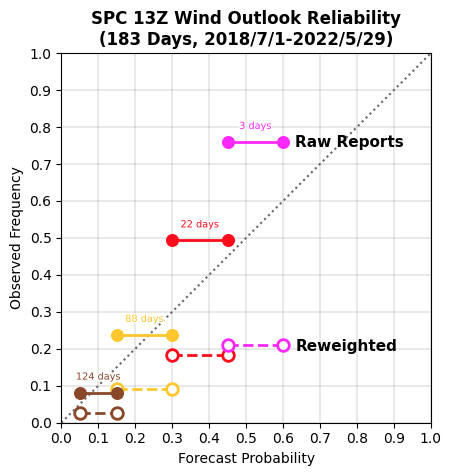

In [8]:
# reliability_plot(f"test_reliability_12z_href_only_more_days_vs_13Z_spc.csv", "SPC 13Z", "spc", "Wind", "wind", wind_hail_colors, 1, 1, min_days=2)
# reliability_plot(f"test_reliability_12z_href_only_more_days_vs_13Z_spc.csv", "SPC 13Z", "spc", "Wind Adjusted", "wind_adj", wind_hail_colors, 1, 1, min_days=2)

csv_path = "test_reliability_12z_href_only_more_days_vs_13Z_spc.csv"
nc_or_spc = "spc"
event_colors = wind_hail_colors
xmax = 1
ymax = 1
min_days = 2

suffix = (re.compile(r"_(\d+)z(_\w+)?\.csv").search(csv_path)[2] or "")

full_df = pd.read_csv(root_in + csv_path)

df = full_df[full_df["event"] == "wind_adj"].copy()
df = df[df["bin_low"] != 0].copy()
df = df[df[f"{nc_or_spc}_bin_days"] >= min_days].copy()
df.index = range(len(df))

fig, ax = plt.subplots()

ax.set_xlim(0,xmax)
ax.set_ylim(0,ymax)
ax.set_xticks(np.arange(0.,xmax + .01,0.1))
ax.set_yticks(np.arange(0.,ymax + .01,0.1))
ax.set_xlabel("Forecast Probability")
ax.set_ylabel("Observed Frequency")
ax.set_aspect(1)
ax.grid(color=(.5,.5,.5), linestyle='-', linewidth=0.25)
ax.set_title(f"SPC 13Z Wind Outlook Reliability\n({df['days_count'][0]} Days, 2018/7/1-2022/5/29)", fontdict={"fontweight":"bold"})

white_outline = [pe.withStroke(linewidth=2, foreground=(1,1,1))]

ax.plot([0,1], [0,1], linewidth=1.5, linestyle=":", color=(0.4,0.4,0.4))

last_x, last_y = (0, 0)

bin_highs = list(df["bin_high_exclusive"])
if len(df) == 1: # SPC Sig
    bin_highs[0] = 1.0

for i in df.index:
    color = lookup(df["bin_low"][i], event_colors)
    ndays = df[f"{nc_or_spc}_bin_days"][i]
#     if i == 0 and len(df) >= 2:
#         ax.text(bin_highs[i] + 0.02*xmax, df[f"{nc_or_spc}_observed_rate"][i], f"{ndays} days", fontsize=7, horizontalalignment="left", va="center", c=color, path_effects=white_outline)
#     else:
#         ax.text(0.5*df["bin_low"][i] + 0.5*min(xmax, bin_highs[i]), df[f"{nc_or_spc}_observed_rate"][i] + 0.01*ymax, f"{ndays} days", fontsize=7, horizontalalignment="center", va="bottom", c=color, path_effects=white_outline)

#     linestyle = "--" if nc_or_spc == "nadocast" else "-"
    marker    = "v" if nc_or_spc == "nadocast" else "o"
    ax.plot([df["bin_low"][i], bin_highs[i]], [df[f"{nc_or_spc}_observed_rate"][i], df[f"{nc_or_spc}_observed_rate"][i]], linestyle="--", linewidth=2, color=color)
    ax.scatter([df["bin_low"][i], bin_highs[i]], [df[f"{nc_or_spc}_observed_rate"][i], df[f"{nc_or_spc}_observed_rate"][i]], s=70, marker=marker, color="white", edgecolors=color, linewidths=2, zorder=2)
    last_x, last_y = (bin_highs[i], df[f"{nc_or_spc}_observed_rate"][i])

if len(df) == 1: # SPC Sig
    ax.text(0.5*df["bin_low"][0] + 0.5*xmax, last_y - 0.02*ymax, label, fontsize=11, horizontalalignment="center", va="top", fontweight="bold")
else:
    ax.text(last_x + 0.033*xmax, last_y - 0.002*ymax, "Reweighted", fontsize=11, horizontalalignment="left", va="center", fontweight="bold")

# ax.bar(df["bin_low"], df[f"{nc_or_spc}_observed_rate_0.975_bootstrap"]-df[f"{nc_or_spc}_observed_rate_0.025_bootstrap"], width=bin_highs-df["bin_low"], bottom=df[f"{nc_or_spc}_observed_rate_0.025_bootstrap"], align="edge", zorder=-1, color=(0,0,0,.08))

full_df = pd.read_csv(root_in + csv_path)

df = full_df[full_df["event"] == "wind"].copy()
df = df[df["bin_low"] != 0].copy()
df = df[df[f"{nc_or_spc}_bin_days"] >= min_days].copy()
df.index = range(len(df))

last_x, last_y = (0, 0)

bin_highs = list(df["bin_high_exclusive"])
if len(df) == 1: # SPC Sig
    bin_highs[0] = 1.0

for i in df.index:
    color = lookup(df["bin_low"][i], event_colors)
    ndays = df[f"{nc_or_spc}_bin_days"][i]
    if False and i == 0 and len(df) >= 2:
        ax.text(bin_highs[i] + 0.02*xmax, df[f"{nc_or_spc}_observed_rate"][i], f"{ndays} days", fontsize=7, horizontalalignment="left", va="center", c=color, path_effects=white_outline)
    else:
        ax.text(0.5*df["bin_low"][i] + 0.5*min(xmax, bin_highs[i]), df[f"{nc_or_spc}_observed_rate"][i] + 0.03*ymax, f"{ndays} days", fontsize=7, horizontalalignment="center", va="bottom", c=color, path_effects=white_outline)

    linestyle = "--" if nc_or_spc == "nadocast" else "-"
    marker    = "v" if nc_or_spc == "nadocast" else "o"
    ax.plot([df["bin_low"][i], bin_highs[i]], [df[f"{nc_or_spc}_observed_rate"][i], df[f"{nc_or_spc}_observed_rate"][i]], linestyle=linestyle, linewidth=2, color=color)
    ax.scatter([df["bin_low"][i], bin_highs[i]], [df[f"{nc_or_spc}_observed_rate"][i], df[f"{nc_or_spc}_observed_rate"][i]], s=70, marker=marker, color=color, zorder=2)
    last_x, last_y = (bin_highs[i], df[f"{nc_or_spc}_observed_rate"][i])

if len(df) == 1: # SPC Sig
    ax.text(0.5*df["bin_low"][0] + 0.5*xmax, last_y - 0.02*ymax, label, fontsize=11, horizontalalignment="center", va="top", fontweight="bold")
else:
    ax.text(last_x + 0.033*xmax, last_y - 0.002*ymax, "Raw Reports", fontsize=11, horizontalalignment="left", va="center", fontweight="bold")

# ax.bar(df["bin_low"], df[f"{nc_or_spc}_observed_rate_0.975_bootstrap"]-df[f"{nc_or_spc}_observed_rate_0.025_bootstrap"], width=bin_highs-df["bin_low"], bottom=df[f"{nc_or_spc}_observed_rate_0.025_bootstrap"], align="edge", zorder=-1, color=(0,0,0,.08))


# (nadocast|spc_day_1)(_href_only|_href_ablations)?(_absolutely_calibrated)?_(tornado|wind|wind_adj|hail|sig_tornado|sig_wind|sig_wind_adj|sig_hail|tornado_\w+_\d+)(_gated_by_\w+)?_(\d{8})_t(\d+)z
t_z    = (re.compile(r"_(\d+)z(_\w+)?\.csv").search(csv_path)[1] or "")
t_z    = "00" if t_z == "0" else t_z
out_path = f"spc_13z_wind_outlook_reliability_{df['days_count'][0]}_days.pdf"
plt.savefig(out_path, dpi=200)
# os.system(f"oxipng -o max --strip safe --libdeflater {out_path}")
plt.show()
